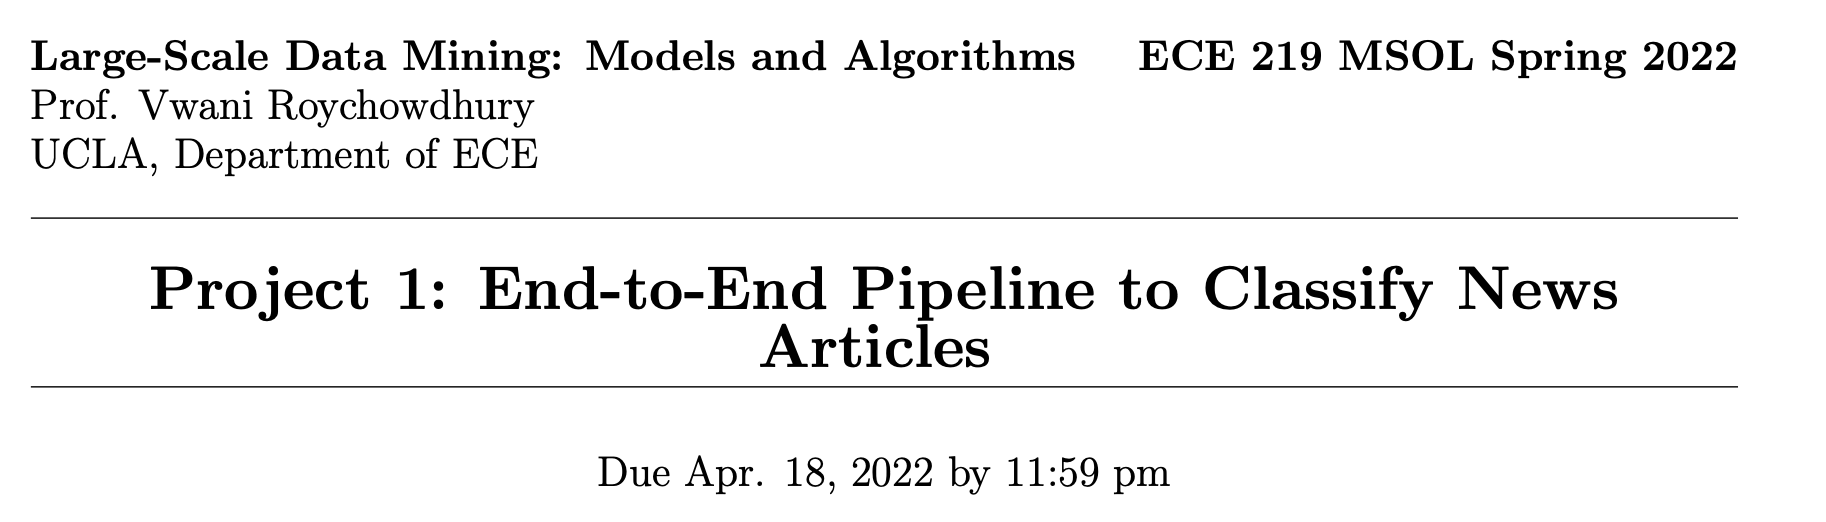

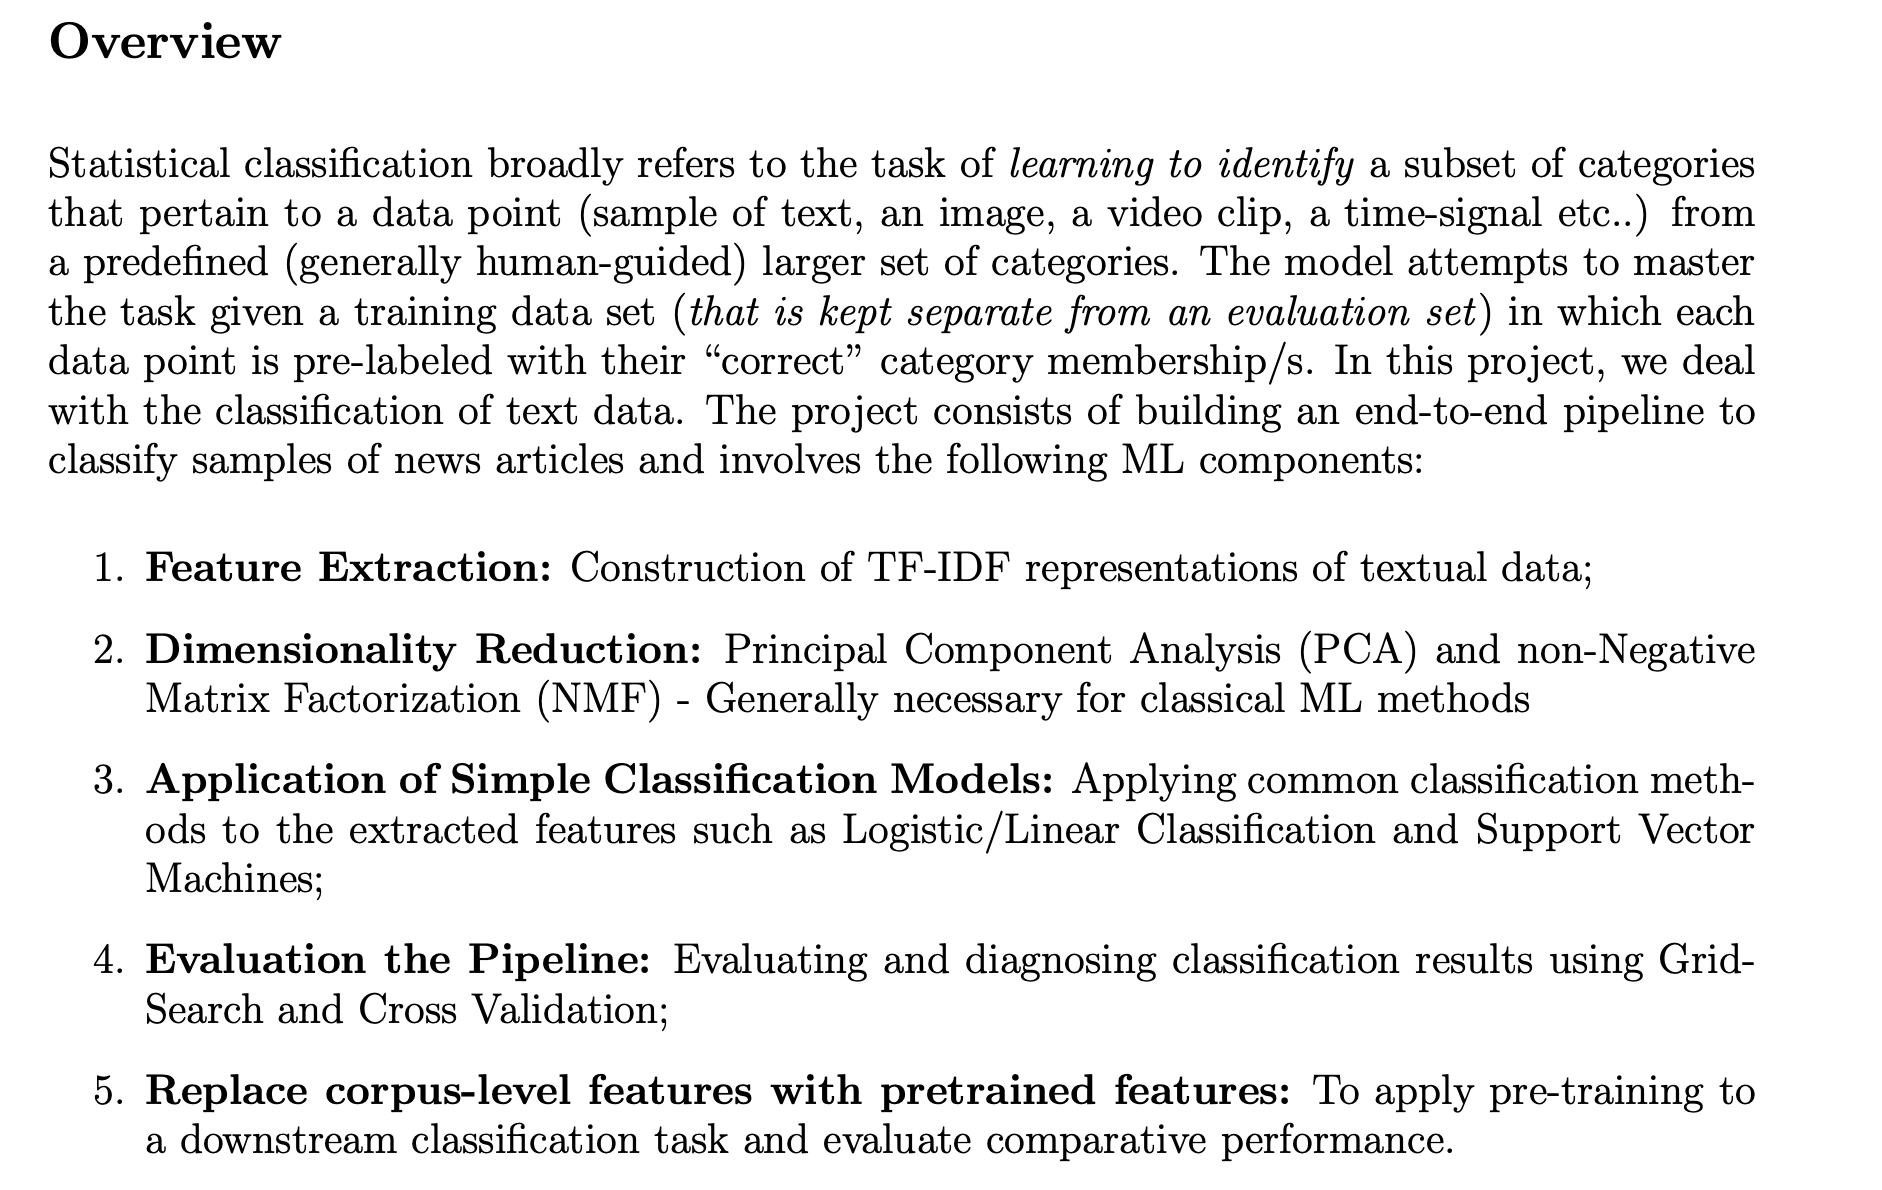

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
import numpy as np
from numpy import array

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils.extmath import randomized_svd


from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline


from sklearn import metrics
from sklearn import svm
from sklearn.svm import SVC # for problem 3

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score # recall scorer
from sklearn.metrics import precision_score # precision scorer
from sklearn.metrics import roc_curve # ROC curve
from sklearn.metrics import f1_score # f1

from nltk import pos_tag

from ast import literal_eval

import nltk

nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


import itertools


import pandas as pd
import seaborn as sns

from tempfile import mkdtemp
from shutil import rmtree
# from sklearn.externals.joblib import Memory

import time
import pickle

# MinMaxScaler for negative values for LSI
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
## HElPER FUNCTIONS
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def get_key(my_dict, val):
    for key, value in my_dict.items():
         if val == value:
             return key

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_parse(text):
    wnl = nltk.wordnet.WordNetLemmatizer()
    lemmatize = []
    for word, tag in pos_tag(nltk.word_tokenize(text)):
        if(not is_number(word)):
            lemmatize.append(wnl.lemmatize(word.lower(), pos=penn2morphy(tag)))
    return lemmatize

def perform_svm_prediction(train_set, test_set, binary_train_target, binary_test_target, gamma='auto', C=1.0, true_labels = []):
    plt.gcf().clear()
    svc = svm.SVC(C = C, probability=True, kernel='linear')
    svc.fit(train_set, binary_train_target)
    svc_predicted = svc.predict(test_set)
    svc_prob = svc.predict_proba(test_set)

    print('gamma: '+ str(gamma))
    print('Accuracy: ' + str(metrics.accuracy_score(binary_test_target.ravel(), svc_predicted)))
    print('Precision: ' + str(metrics.precision_score(binary_test_target.ravel(), svc_predicted)))
    print('Recall: ' + str(metrics.recall_score(binary_test_target.ravel(), svc_predicted)))
    print('F-1 Score: ' + str(metrics.f1_score(binary_test_target.ravel(), svc_predicted)))
    
    #compute confusion matrix
    cm = metrics.confusion_matrix(binary_test_target, svc_predicted)

    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cm)
    plt.show() 
    
    # calculate fpr_tpr
    fpr, tpr, thresholds = metrics.roc_curve(binary_test_target, svc_prob[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    # plot_roc_curve(fpr, tpr, roc_auc)
    return fpr, tpr, roc_auc
    
def plot_confusion_matrix(cm):
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['Sports', 'Climate']); ax.yaxis.set_ticklabels(['Sports', 'Climate']);

def plot_confusion_matrix_multi(cm, labels):
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

def plot_roc_curve(fpr, tpr, auc):
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.1, 1.1])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate or (1 - Specifity)')
  plt.ylabel('True Positive Rate or (Sensitivity)')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")

def perform_lr_prediction(lr_model_predicted, lr_model_prob, train_set, test_set, binary_train_target, binary_test_target, gamma='auto'):
    plt.gcf().clear()

    print('gamma: '+ str(gamma))
    print('Accuracy: ' + str(metrics.accuracy_score(binary_test_target.ravel(), lr_model_predicted)))
    print('Precision: ' + str(metrics.precision_score(binary_test_target.ravel(), lr_model_predicted)))
    print('Recall: ' + str(metrics.recall_score(binary_test_target.ravel(), lr_model_predicted)))
    print('F-1 Score: ' + str(metrics.f1_score(binary_test_target.ravel(), lr_model_predicted)))
    
    #compute confusion matrix
    cm = metrics.confusion_matrix(binary_test_target, lr_model_predicted)

    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cm)
    plt.show() 
    
    # calculate fpr_tpr
    fpr, tpr, thresholds = metrics.roc_curve(binary_test_target, lr_model_prob[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    plot_roc_curve(fpr, tpr, roc_auc)
    plt.show()

def perform_naive_bayes_prediction(train_set, test_set, binary_train_target, binary_test_target):
    plt.gcf().clear()
    gnb = GaussianNB()
    gnb.fit(train_set, binary_train_target)
    pred = gnb.predict(test_set)
    prob = gnb.predict_proba(test_set)

    print('Accuracy: ' + str(metrics.accuracy_score(binary_test_target.ravel(), pred)))
    print('Precision: ' + str(metrics.precision_score(binary_test_target.ravel(), pred)))
    print('Recall: ' + str(metrics.recall_score(binary_test_target.ravel(), pred)))
    print('F-1 Score: ' + str(metrics.f1_score(binary_test_target.ravel(), pred)))
    
    #compute confusion matrix
    cm = metrics.confusion_matrix(binary_test_target, pred)

    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cm)
    plt.show() 
    
    # calculate fpr_tpr
    fpr, tpr, thresholds = metrics.roc_curve(binary_test_target, prob[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    plot_roc_curve(fpr, tpr, roc_auc)
    plt.show()

def load_glove_embeddings(dimension_of_glove):
  embeddings_dict = {}
  with open("drive/MyDrive/ECE219/glove/glove.6B." + str(dimension_of_glove) + "d.txt", 'r') as f:
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector
  return embeddings_dict

def glove_feature_processing(data, dimension_of_glove, embeddings_dict):
  nltk.download('words')
  wnl = nltk.wordnet.WordNetLemmatizer()
  words = set(nltk.corpus.words.words())
  vector_aggregator = np.zeros((np.shape(data)[0], dimension_of_glove))
  for i, row in data.reset_index().iterrows():
    vector_matrix = []
    for j, item in enumerate(literal_eval(row['keywords'])):
      if item.lower() in words:
        word_lemmatized = wnl.lemmatize(item)
        try:
          vector_matrix.append(embeddings_dict[word_lemmatized])
        except:
          continue
    vector_matrix = np.array(vector_matrix)
    vector_matrix = np.mean(vector_matrix,axis=0)
    vector_matrix /= np.linalg.norm(vector_matrix)
    vector_aggregator[i] = vector_matrix
  return vector_aggregator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nltk

In [ ]:
import pandas as pd
import os

PATH = 'drive/MyDrive/ECE219/'

def load_article_data(path=PATH): 
    csv_path = os.path.join(path, "Project_1_dataset_01_01_2022.csv") 
    return pd.read_csv(csv_path)

news_articles = load_article_data()

news_articles.head()

Unnamed: 0                                          full_text  \
0         590  Having made a massive impact in Saudi Arabia w...   
1         388  Cricket is all about the emotional rollercoast...   
2         423  New Zealand announces back-to-back tours next ...   
3         563  It's not the first time cricket fans in the co...   
4         634  An employee works on a computer terminal again...   

                                             summary  \
0  Having made a massive impact in Saudi Arabia w...   
1  No matter which team fans hope to win, every s...   
2  New Zealand announces back-to-back tours next ...   
3  Billed as one of the pre-tournament favourites...   
4  REUTERS/Sivaram VBENGALURU, Oct 11 (Reuters Br...   

                                            keywords         publish_date  \
0  ['singhs', 'rooting', 'cool', 'saudi', 'style'...                  NaN   
1  ['wants', 'fans', 'finals', 'cup', 'win', 'tou...                  NaN   
2  ['test', 'west', 'tour', 'zealand', 'world', '...  2021-12-20 00:00:00   
3  ['qualify', 'afghanistan', 'cup', 'world', 'ze...                  NaN   
4  ['success', 'tech', 'startup', 'talent', 'onli...  2021-10-11 00:00:00   

          authors                                                url  \
0              []  https://www.msn.com/en-in/entertainment/other/...   
1              []  https://www.prnewswire.com:443/news-releases/c...   
2              []  https://www.aljazeera.com/news/2021/12/20/cric...   
3              []  https://www.msn.com/en-in/news/other/t20-world...   
4  ['Una Galani']  https://www.reuters.com/breakingviews/india-in...   

  leaf_label root_label  
0    cricket     sports  
1    cricket     sports  
2    cricket     sports  
3    cricket     sports  
4    cricket     sports

In [ ]:
news_articles.shape

(2072, 9)

# QUESTION 1: 

Provide answers to the following questions:
- ***Overview:*** How many rows (samples) and columns (features) are present in the dataset? We got about 2000 samples.

- ***Histograms:*** Plot 3 histograms on : (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis; (b) The column leaf label – class on the x-axis; (c) The column root label – class on the x-axis.

- ***Interpret Plots:*** Provide qualitative interpretations of the histograms.

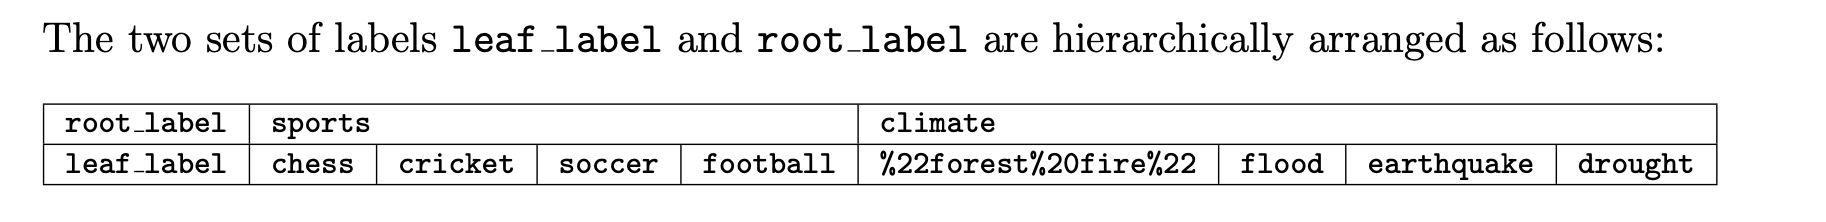


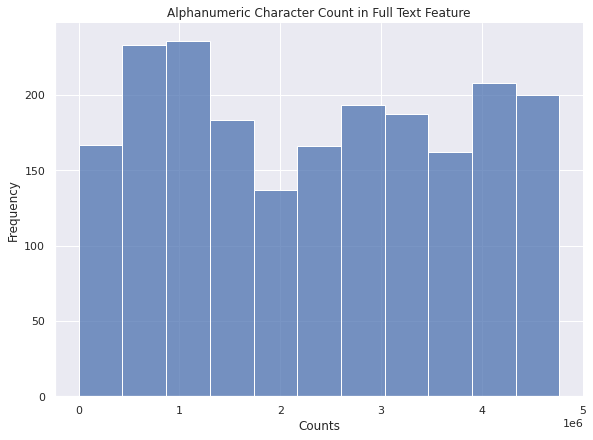

In [ ]:
# Alpha numeric chars in full_text feature
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set(style='darkgrid')

alphanum_chars_per_row = []
count=0

for row in news_articles.itertuples(index=False):
    row_string = str(row.full_text)
    for i in row_string:
        if(i.isalpha()):
            count=count+1   # Increment Count by 1
        elif(i.isdigit()):
            count=count+1
            
    alphanum_chars_per_row.append(count)

# figure(figsize=(20, 10), dpi=100)
# (n, bins, patches) = plt.hist(alphanum_chars_per_row, bins = 11)
# plt.show()
fig = sns.displot(data=alphanum_chars_per_row, kind='hist', height=6, aspect=1.4, bins=11).set(title="Alphanumeric Character Count in Full Text Feature")
fig.set_axis_labels('Counts', 'Frequency')

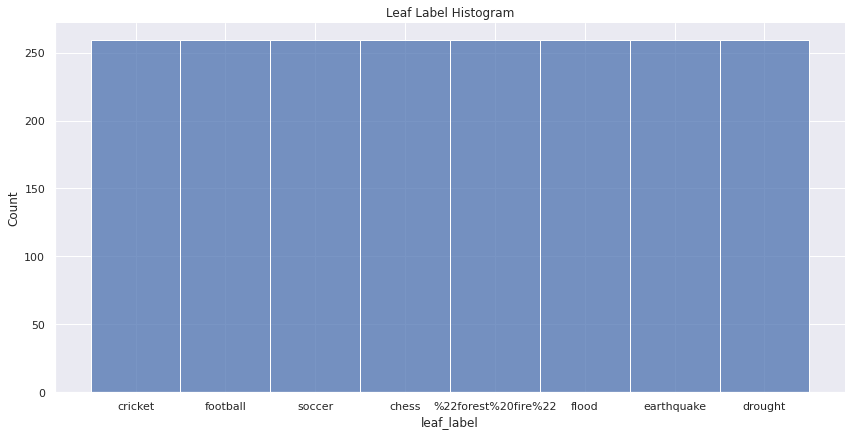

In [ ]:
fig = sns.displot(data=news_articles, x = 'leaf_label', kind='hist', height=6, aspect=2).set(title="Leaf Label Histogram")

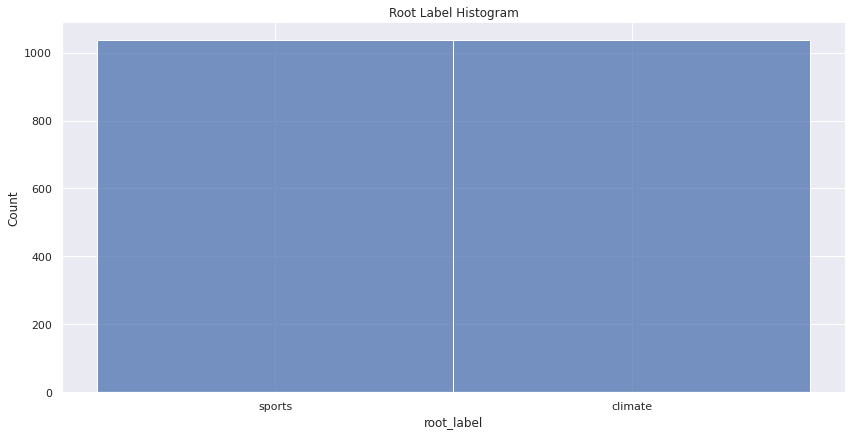

In [ ]:
fig = sns.displot(data=news_articles, x = 'root_label', kind='hist', height=6, aspect=2).set(title="Root Label Histogram")

# Binary Classification

In [ ]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

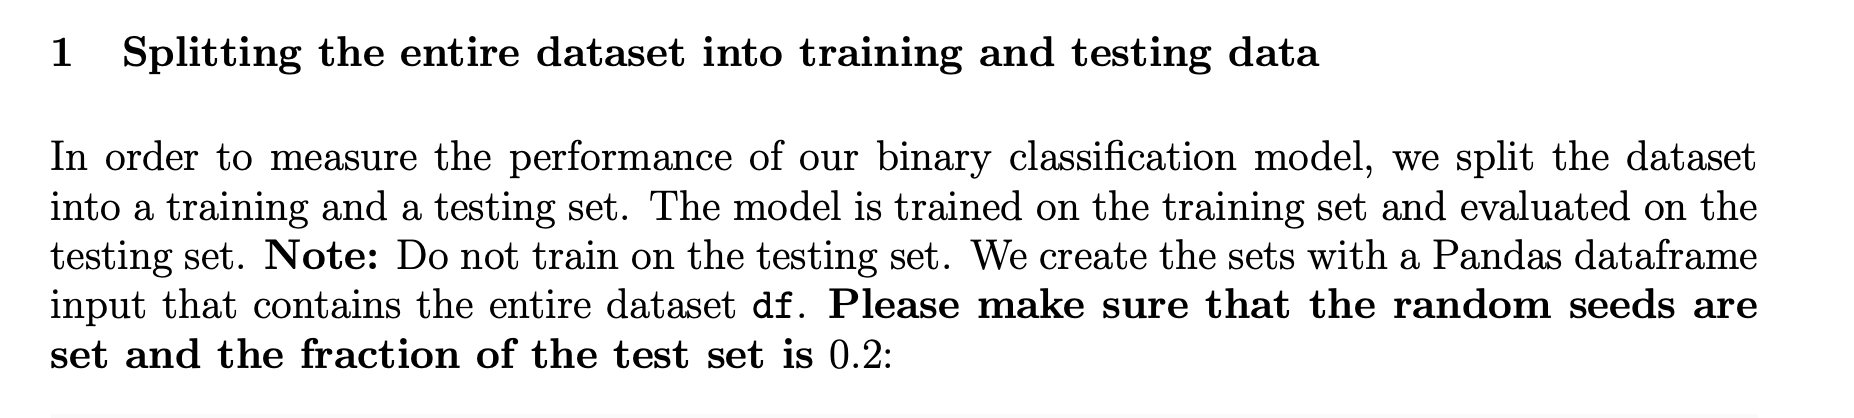

# QUESTION 2: 
Report the number of training and testing samples.
Hint: You should have about 1650 samples in the training set and about 400 samples in the testing set.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(news_articles[["full_text","root_label"]], test_size=0.2)
print(np.shape(train))
print(np.shape(test))

(1657, 2)
(415, 2)


In [ ]:
list_train = train.full_text.tolist()
list_train = [clean(doc) for doc in list_train]
target_train = train.root_label.tolist()
target_train = (train.root_label == 'sports')

list_test = test.full_text.tolist()
list_test = [clean(doc) for doc in list_test]
truth_test_labels = test.root_label.tolist()
target_test = (test.root_label == 'sports')
target_test

1351    False
733      True
678      True
1460    False
411      True
        ...  
772      True
593      True
1674    False
881      True
2027    False
Name: root_label, Length: 415, dtype: bool

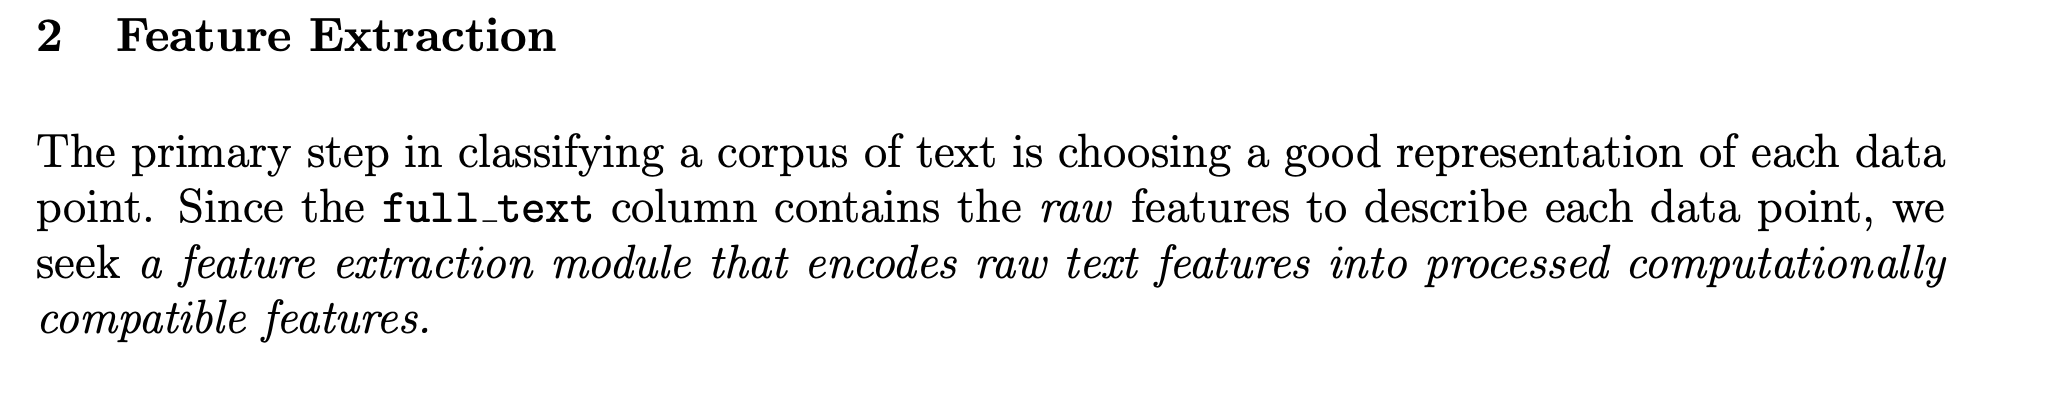

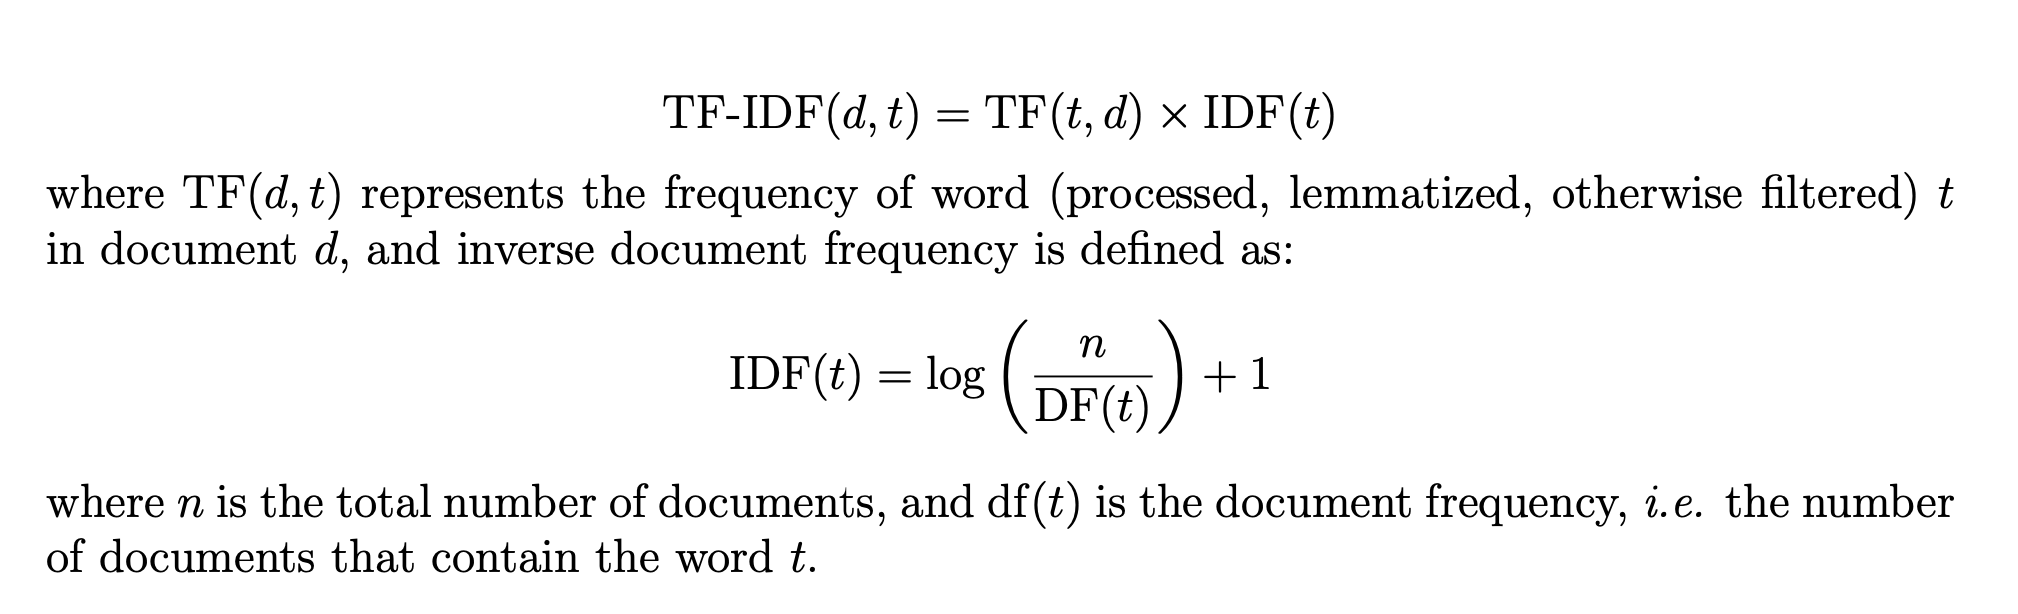

# QUESTION 3: 
Use the following specs to extract features from the textual data:

- Before doing anything, please clean each data sample using the code block provided above. This function helps remove many but not all HTML artefacts from the crawler’s output. You can also build your own cleaning module if you find this function to be ineffective.

  • Use the “english” stopwords of the CountVectorizer

  • Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
  • Perform lemmatization with nltk.wordnet. WordNetLemmatizer and pos tag 
    
       --Use min df=3

- Please answer the following questions:
  
  • What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?
  
  • min df means minimum document frequency. How does varying min df change the TF-IDF matrix?
  
  • Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing?
  
  • Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×103. This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.

In [ ]:
import time

t1 = time.time()
print("Lemmatizing training set")
train_dataset_lemmatized = []
for item in list_train:
    train_dataset_lemmatized.append(' '.join(lemmatize_parse(item)))
print("Completed lemmatization of training set in %f sec\n" %(time.time()-t1))
print(len(train_dataset_lemmatized))

t1 = time.time()
print("Lemmatizing test set")
test_dataset_lemmatized = []
for item in list_test:
    test_dataset_lemmatized.append(' '.join(lemmatize_parse(item)))
print("Completed lemmatization of testing set in %f sec\n" %(time.time()-t1))
print(len(test_dataset_lemmatized))

Lemmatizing training set
Completed lemmatization of training set in 68.541964 sec

1657
Lemmatizing test set
Completed lemmatization of testing set in 11.113284 sec

415


In [ ]:
# vectorize - fit and transform
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_train_counts = vectorizer.fit_transform(train_dataset_lemmatized)
X_test_counts = vectorizer.transform(test_dataset_lemmatized)
print(X_train_counts.shape)
print(X_test_counts.shape)

(1657, 10441)
(415, 10441)


In [ ]:
# generate TFxIDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [ ]:
print('X_train_tfidf:',X_train_tfidf.shape)
print('X_test_tfidf:', X_test_tfidf.shape)

X_train_tfidf: (1657, 10441)
X_test_tfidf: (415, 10441)


## Varying the min_df and plotting size of TF_IDF Matrix

0.01
0.1
0.2
0.3
0.4
0.5


Text(0, 0.5, 'Size of TF-IDF Matrix')

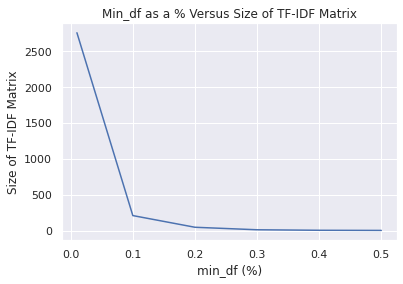

In [ ]:
%matplotlib inline

min_dfs = [.01, .1, .2, .3, .4, .5]
size = []

for df in min_dfs:
  print(df)
  vectorizer = CountVectorizer(min_df=df, stop_words='english')
  X = vectorizer.fit_transform(train_dataset_lemmatized)
  X_idf = tfidf_transformer.fit_transform(X)
  size.append(X_idf.shape[1])

plt.plot(min_dfs, size)
plt.title('Min_df as a % Versus Size of TF-IDF Matrix')
plt.xlabel('min_df (%)')
plt.ylabel('Size of TF-IDF Matrix')


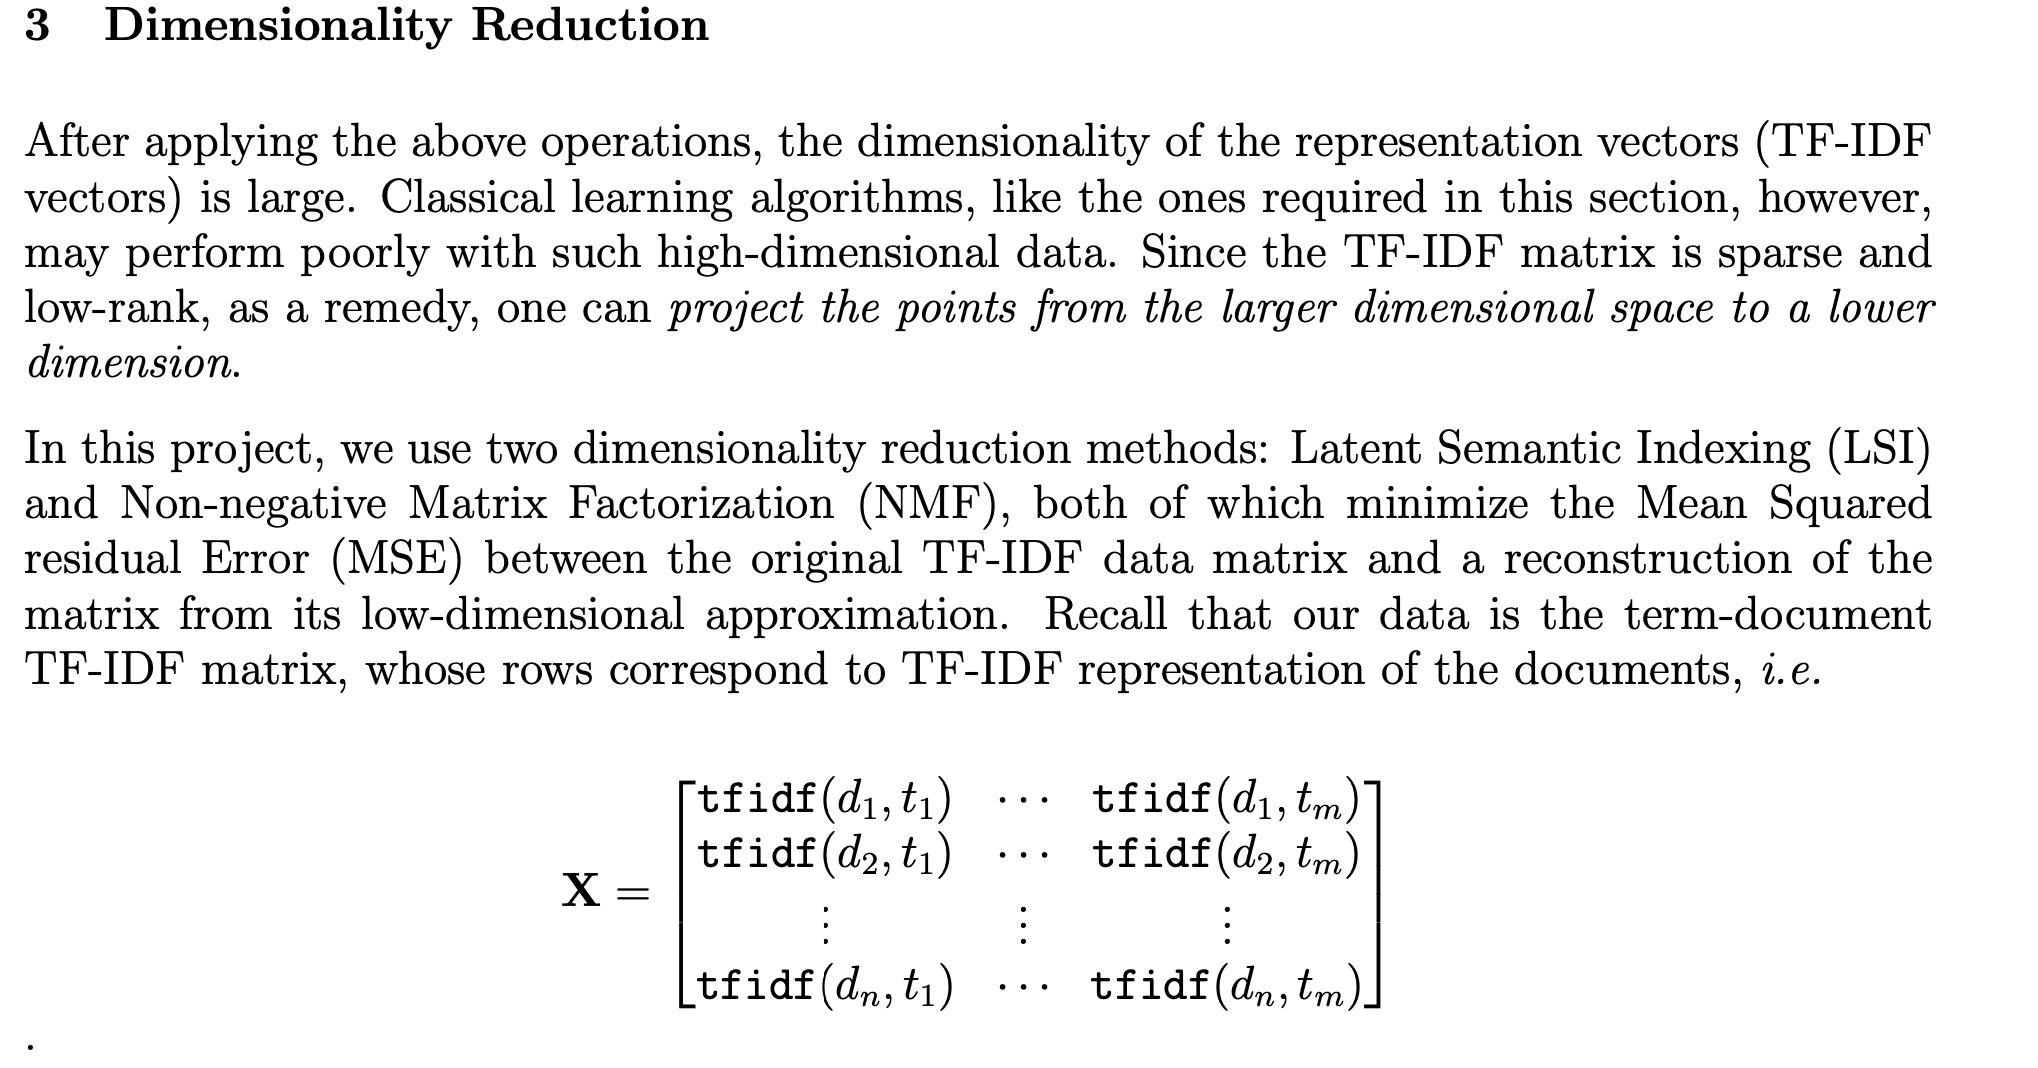

# QUESTION 4: 

Reduce the dimensionality of the data using the methods above:

  • Plot the explained variance ratio across multiple different k = [1, 10, 50, 100, 200, 500, 1000, 2000] for LSI and for the next few sections choose k = 50. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?

  • With k = 50 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 50. Which one is larger?

## Plotting Explained Variance Ratio

Text(0, 0.5, 'Explained Variance Ratio')

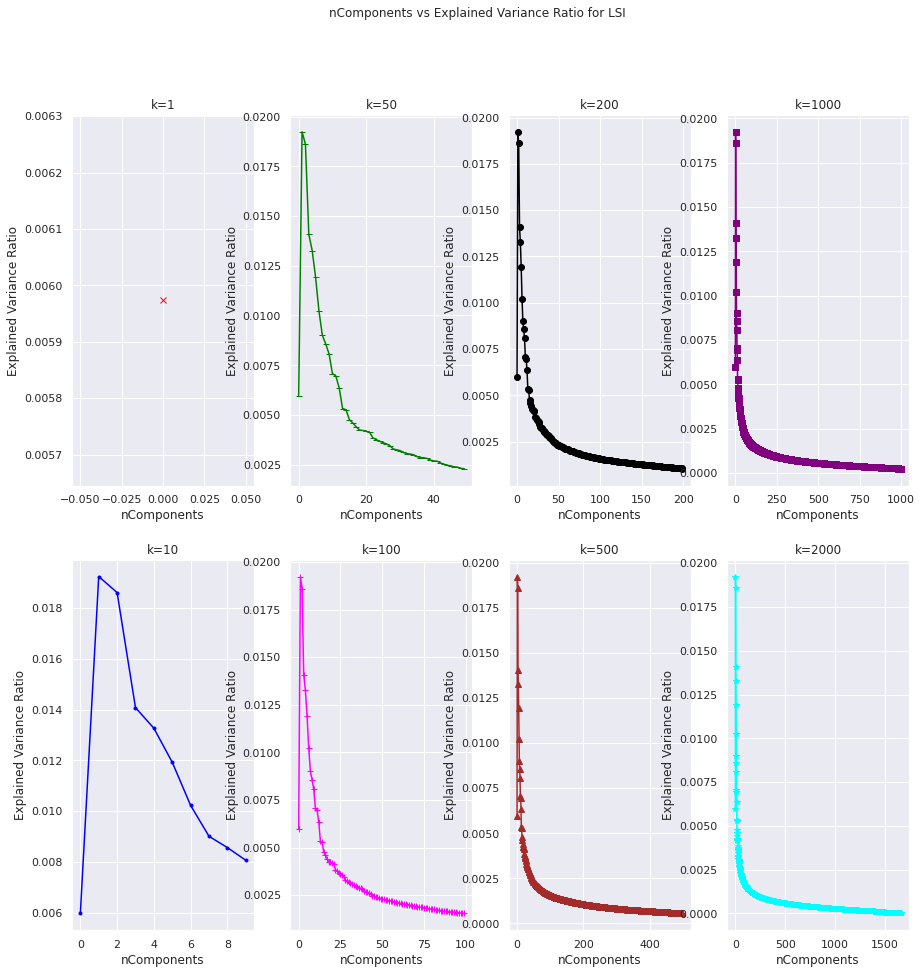

In [ ]:
colors = ['red', 'blue', 'green', 'magenta', 'black', 'brown', 'purple', 'cyan']
markers = ["x", ".", "_", "+", "o", "^", "s", "*"]
explained_variance_ratio_list = []
counter = 0
%matplotlib inline

for i in [1, 10, 50, 100, 200, 500, 1000, 2000]:
  lsi = TruncatedSVD(n_components = i, n_iter = 10, random_state = 42)
  lsi_train = lsi.fit_transform(X_train_tfidf)
  explained_variance_ratio_list.append(lsi.explained_variance_ratio_)

fig, axs = plt.subplots(2, 4, figsize=(15,15))

fig.suptitle('nComponents vs Explained Variance Ratio for LSI', FontSize=20)
axs[0, 0].plot(explained_variance_ratio_list[0], color=colors[0], marker = markers[0])
axs[0, 0].set_title('k=1')
axs[0, 0].set_xlabel('nComponents')
axs[0, 0].set_ylabel('Explained Variance Ratio')
axs[1, 0].plot(explained_variance_ratio_list[1], color=colors[1], marker = markers[1])
axs[1, 0].set_title('k=10')
axs[1, 0].set_xlabel('nComponents')
axs[1, 0].set_ylabel('Explained Variance Ratio')
axs[0, 1].plot(explained_variance_ratio_list[2], color=colors[2], marker = markers[2])
axs[0, 1].set_title('k=50')
axs[0, 1].set_xlabel('nComponents')
axs[0, 1].set_ylabel('Explained Variance Ratio')
axs[1, 1].plot(explained_variance_ratio_list[3], color=colors[3], marker = markers[3])
axs[1, 1].set_title('k=100')
axs[1, 1].set_xlabel('nComponents')
axs[1, 1].set_ylabel('Explained Variance Ratio')
axs[0, 2].plot(explained_variance_ratio_list[4], color=colors[4], marker = markers[4])
axs[0, 2].set_title('k=200')
axs[0, 2].set_xlabel('nComponents')
axs[0, 2].set_ylabel('Explained Variance Ratio')
axs[1, 2].plot(explained_variance_ratio_list[5], color=colors[5], marker = markers[5])
axs[1, 2].set_title('k=500')
axs[1, 2].set_xlabel('nComponents')
axs[1, 2].set_ylabel('Explained Variance Ratio')
axs[0, 3].plot(explained_variance_ratio_list[6], color=colors[6], marker = markers[6])
axs[0, 3].set_title('k=1000')
axs[0, 3].set_xlabel('nComponents')
axs[0, 3].set_ylabel('Explained Variance Ratio')
axs[1, 3].plot(explained_variance_ratio_list[7], color=colors[7], marker = markers[7])
axs[1, 3].set_title('k=2000')
axs[1, 3].set_xlabel('nComponents')
axs[1, 3].set_ylabel('Explained Variance Ratio')
# plt.title('Explained Variance Ratio Across Different nComponents')
# plt.gca().legend(('k=1', 'k=10', 'k=50', 'k=100', 'k=200', 'k=500', 'k=1000', 'k=2000'))
# plt.xlabel('nComponents')
# plt.ylabel('Explained Variance Ratio')

In [ ]:
# using LSI
lsi = TruncatedSVD(n_components = 50,n_iter = 10, random_state = 42)
lsi_train = lsi.fit_transform(X_train_tfidf)
lsi_test = lsi.transform(X_test_tfidf)
print('LSI train:')
print(lsi_train.shape)
print('LSI test:')
print(lsi_test.shape)
print('')

# using NMF
nmf = NMF(n_components=50, init='random', random_state=42)
nmf_train = nmf.fit_transform(X_train_tfidf)
nmf_test = nmf.transform(X_test_tfidf)
print('NMF train:')
print(nmf_train.shape)
print('NMF test:')
print(nmf_test.shape)
print('')


LSI train:
(1657, 50)
LSI test:
(415, 50)

NMF train:
(1657, 50)
NMF test:
(415, 50)



/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [ ]:
# Use Approximated SVD to calculate reconstruction MSE Error for LSI
# Use WH calculated matrix to calculate reconstruction MSE error for NMF

u,sigma,vt = randomized_svd(X_train_tfidf, n_components=50)
x_50 = np.dot(np.dot(u,np.diag(sigma)),vt)
lsi_frobenius = np.sqrt(np.sum(np.square(x_50-X_train_tfidf)))
print("Frobenius Norm for LSI: \n" + str(lsi_frobenius))

WH = np.dot(nmf_train, nmf.components_)
nmf_frobenius = np.sqrt(np.sum(np.square(WH-X_train_tfidf)))
print("NMF Frobenius Norm:\n" + str(nmf_frobenius))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


Frobenius Norm for LSI: 
34.390447642814436
NMF Frobenius Norm:
34.72713958285293


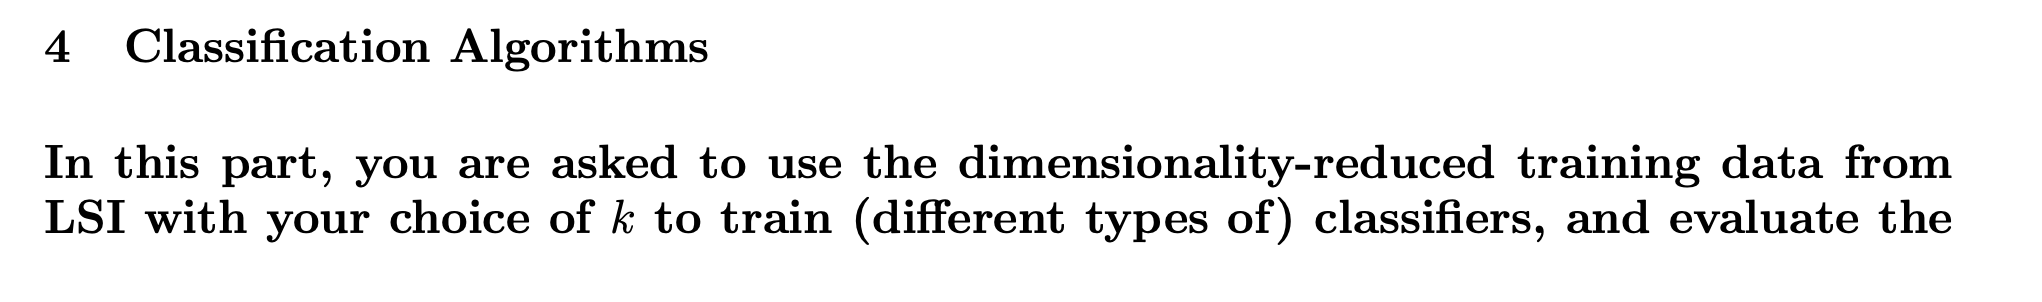

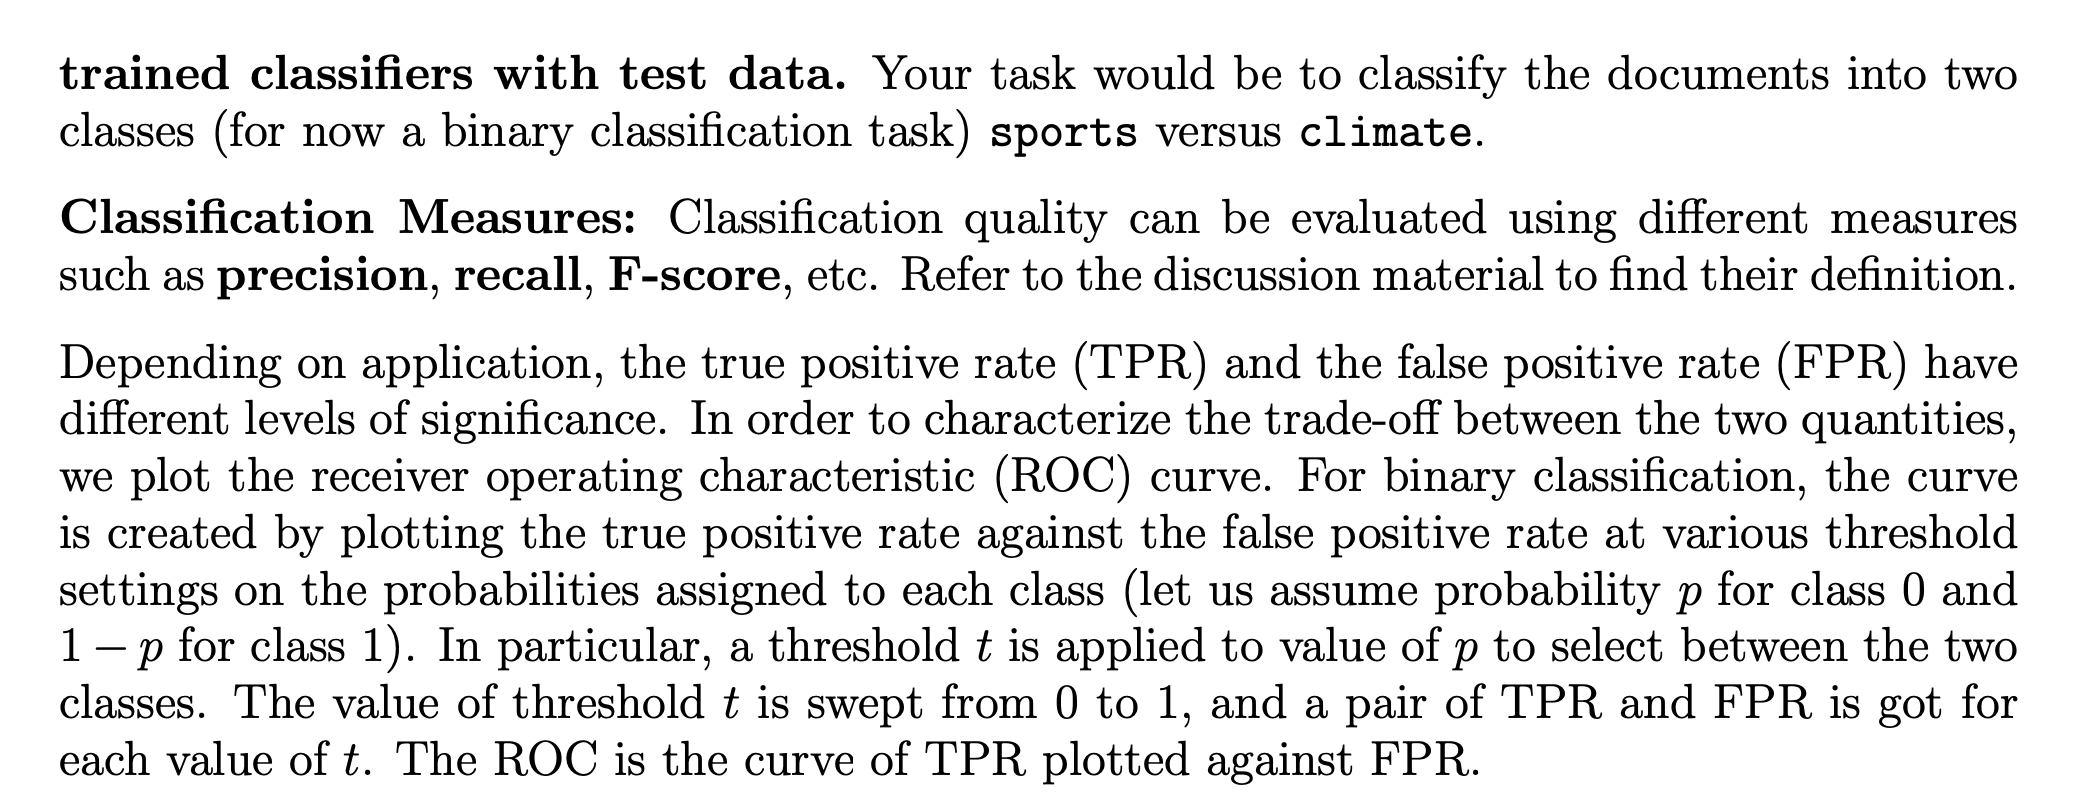

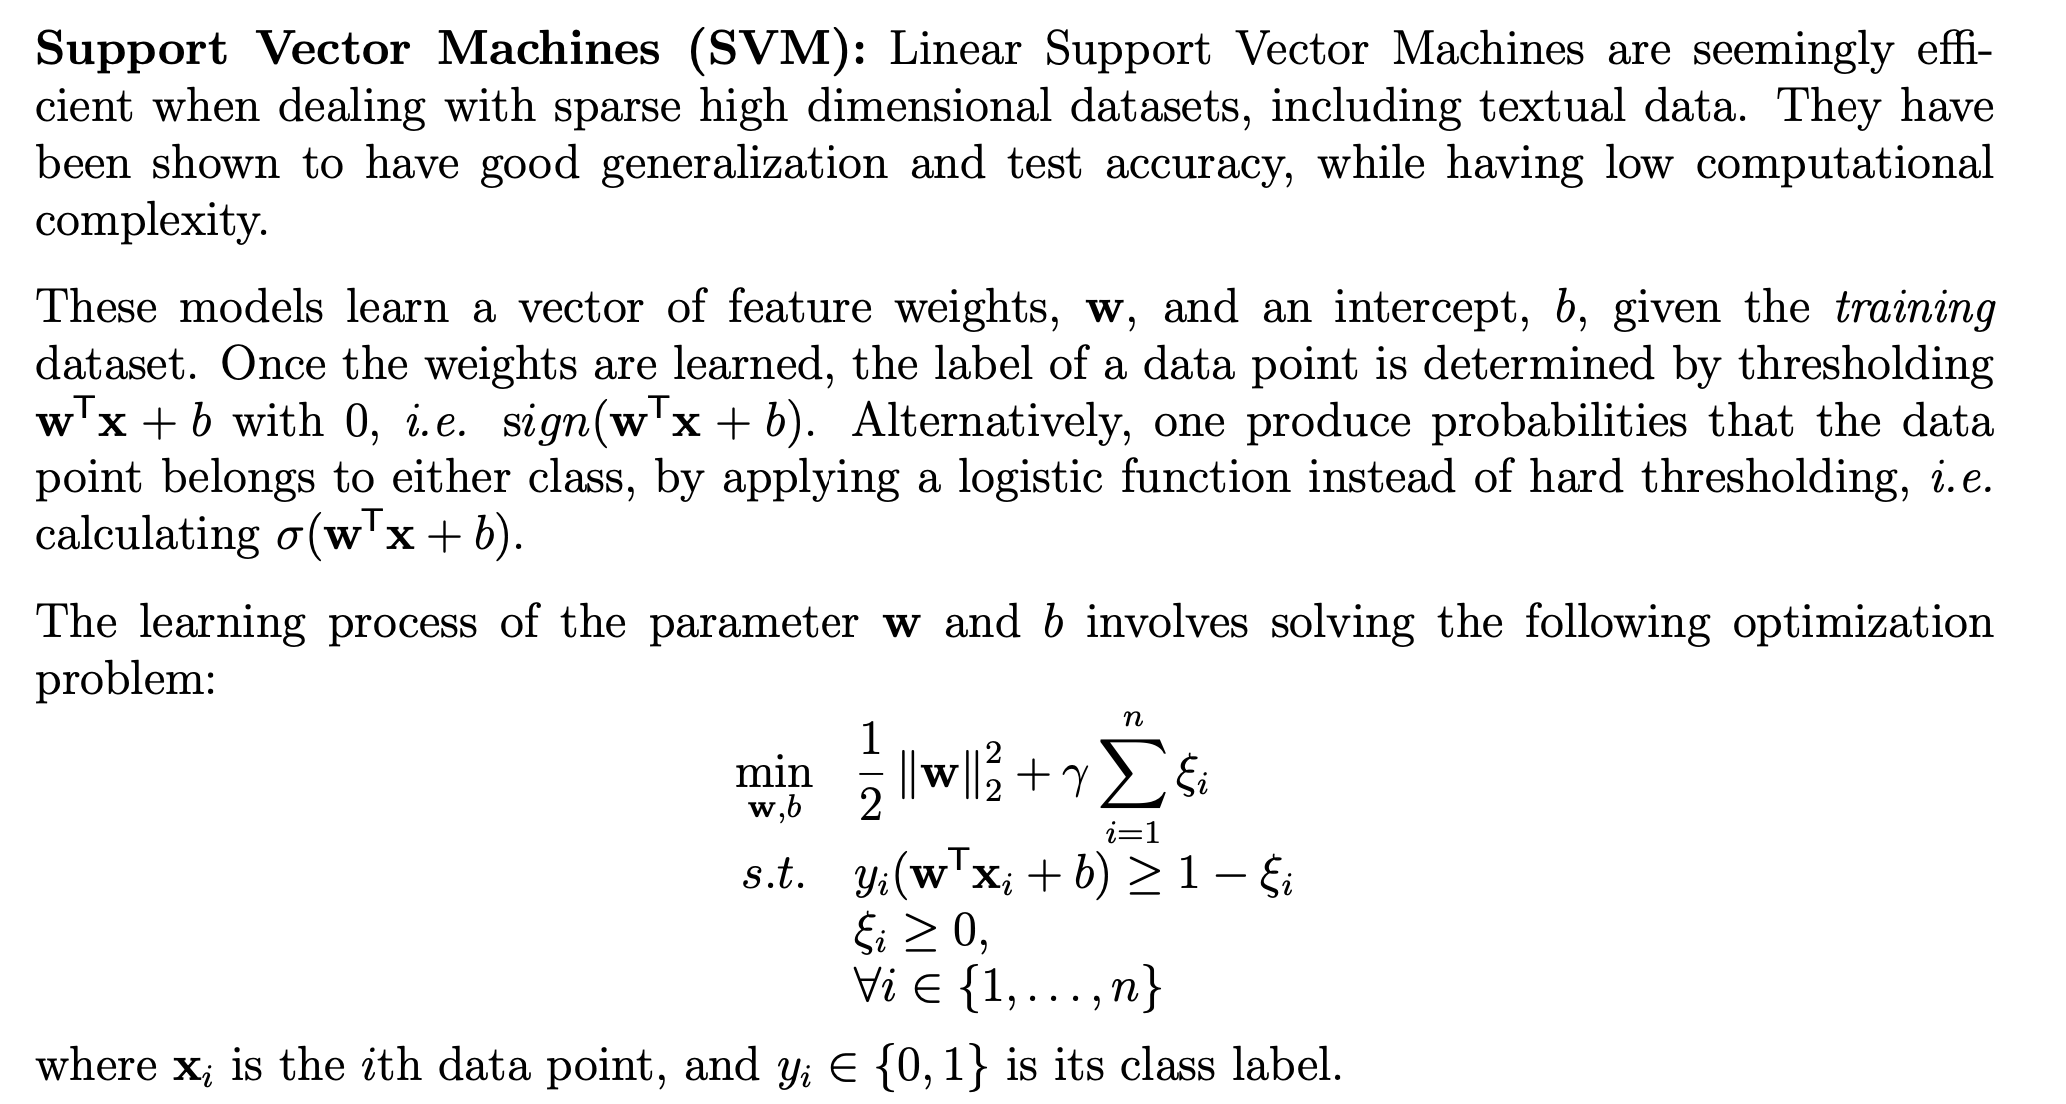

#QUESTION 5: 
Compare and contrast hard-margin and soft-margin linear SVMs:

 • Train two linear SVMs:

    – Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin).

    – Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?

    – What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.

∗ Does the ROC curve of the soft margin SVM look competitive? Please explain.

    • Use cross-validation to choose γ (use average validation 3 accuracy to compare):

  
Using a 5-fold cross-validation, find the best value of the parameter γ in the range {10k| − 3 ≤ k ≤ 6,k ∈ Z}. Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.

gamma: auto
Accuracy: 0.9686746987951808
Precision: 0.9579439252336449
Recall: 0.9808612440191388
F-1 Score: 0.9692671394799054


<Figure size 432x288 with 0 Axes>

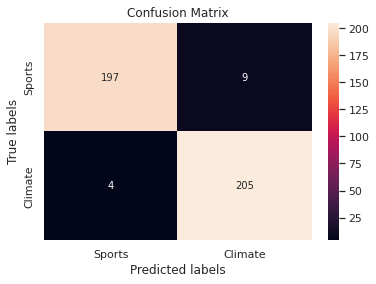

In [ ]:
# Hard Margin SVM

fpr_1000, tpr_1000, auc_1000 = perform_svm_prediction(lsi_train, lsi_test, target_train, target_test, C=1000, true_labels=truth_test_labels)

gamma: auto
Accuracy: 0.5566265060240964
Precision: 1.0
Recall: 0.11961722488038277
F-1 Score: 0.21367521367521367


<Figure size 432x288 with 0 Axes>

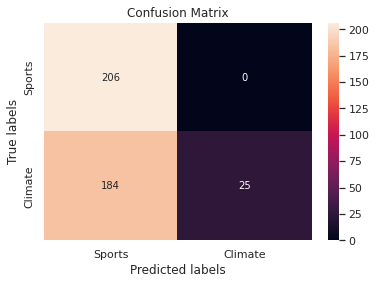

In [ ]:
# Soft Margin SVM

fpr_01, tpr_01, auc_01 = perform_svm_prediction(lsi_train, lsi_test, target_train, target_test, C=.01, true_labels=truth_test_labels)

gamma: auto
Accuracy: 0.9686746987951808
Precision: 0.9537037037037037
Recall: 0.9856459330143541
F-1 Score: 0.9694117647058824


<Figure size 432x288 with 0 Axes>

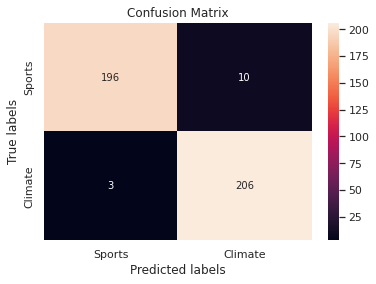

In [ ]:
# Hardest SVM

fpr_100k, tpr_100k, auc_100k = perform_svm_prediction(lsi_train, lsi_test, target_train, target_test, C=100000, true_labels=truth_test_labels)

## Using Cross Validation to Select the Best Gamma

In [ ]:
parameters = {'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4,10**5,10**6]}
svm_model = svm.SVC(probability = True)
svm_grid = GridSearchCV(svm_model, parameters, cv=5)
svm_grid.fit(lsi_train, target_train)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000,
                               100000, 1000000]})

In [ ]:
pd.DataFrame(svm_grid.cv_results_)[['param_C','mean_test_score']]

param_C  mean_test_score
0    0.001         0.500906
1     0.01         0.701287
2      0.1         0.946888
3        1         0.949299
4       10         0.956539
5      100         0.954122
6     1000         0.949893
7    10000         0.949893
8   100000         0.949893
9  1000000         0.949893

gamma: auto
Accuracy: 0.9734939759036144
Precision: 0.9626168224299065
Recall: 0.9856459330143541
F-1 Score: 0.9739952718676123


<Figure size 432x288 with 0 Axes>

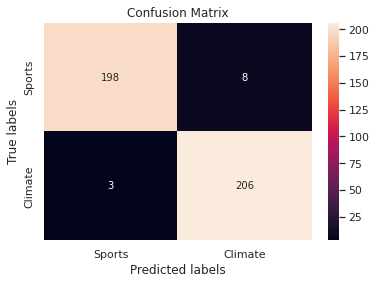

In [ ]:
# C = 10 got the best mean test score based on the cross fold validation procedure

fpr_10, tpr_10, auc_10 = perform_svm_prediction(lsi_train, lsi_test, target_train, target_test, C=10)

### Compare and Plot ROC Curves

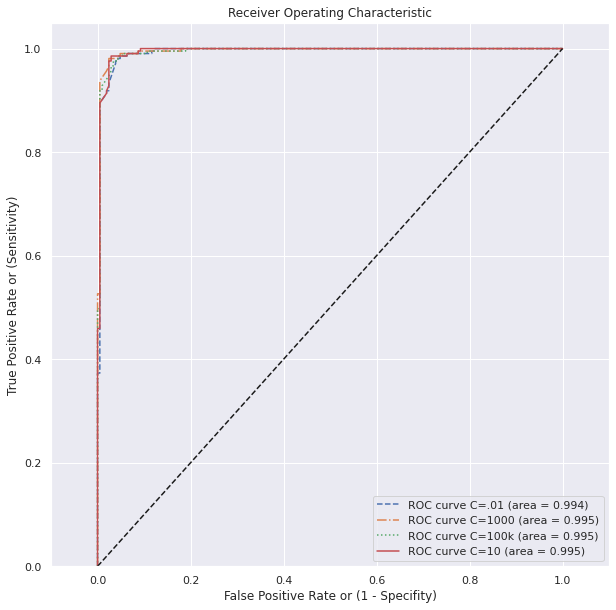

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.plot(fpr_01, tpr_01, linestyle = 'dashed', label='ROC curve C=.01 (area = %0.3f)' % auc_01)
plt.plot(fpr_1000, tpr_1000, linestyle='dashdot', label='ROC curve C=1000 (area = %0.3f)' % auc_1000)
plt.plot(fpr_100k, tpr_100k, linestyle='dotted', label='ROC curve C=100k (area = %0.3f)' % auc_100k)
plt.plot(fpr_10, tpr_10, linestyle='solid', label='ROC curve C=10 (area = %0.3f)' % auc_10)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-.1, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

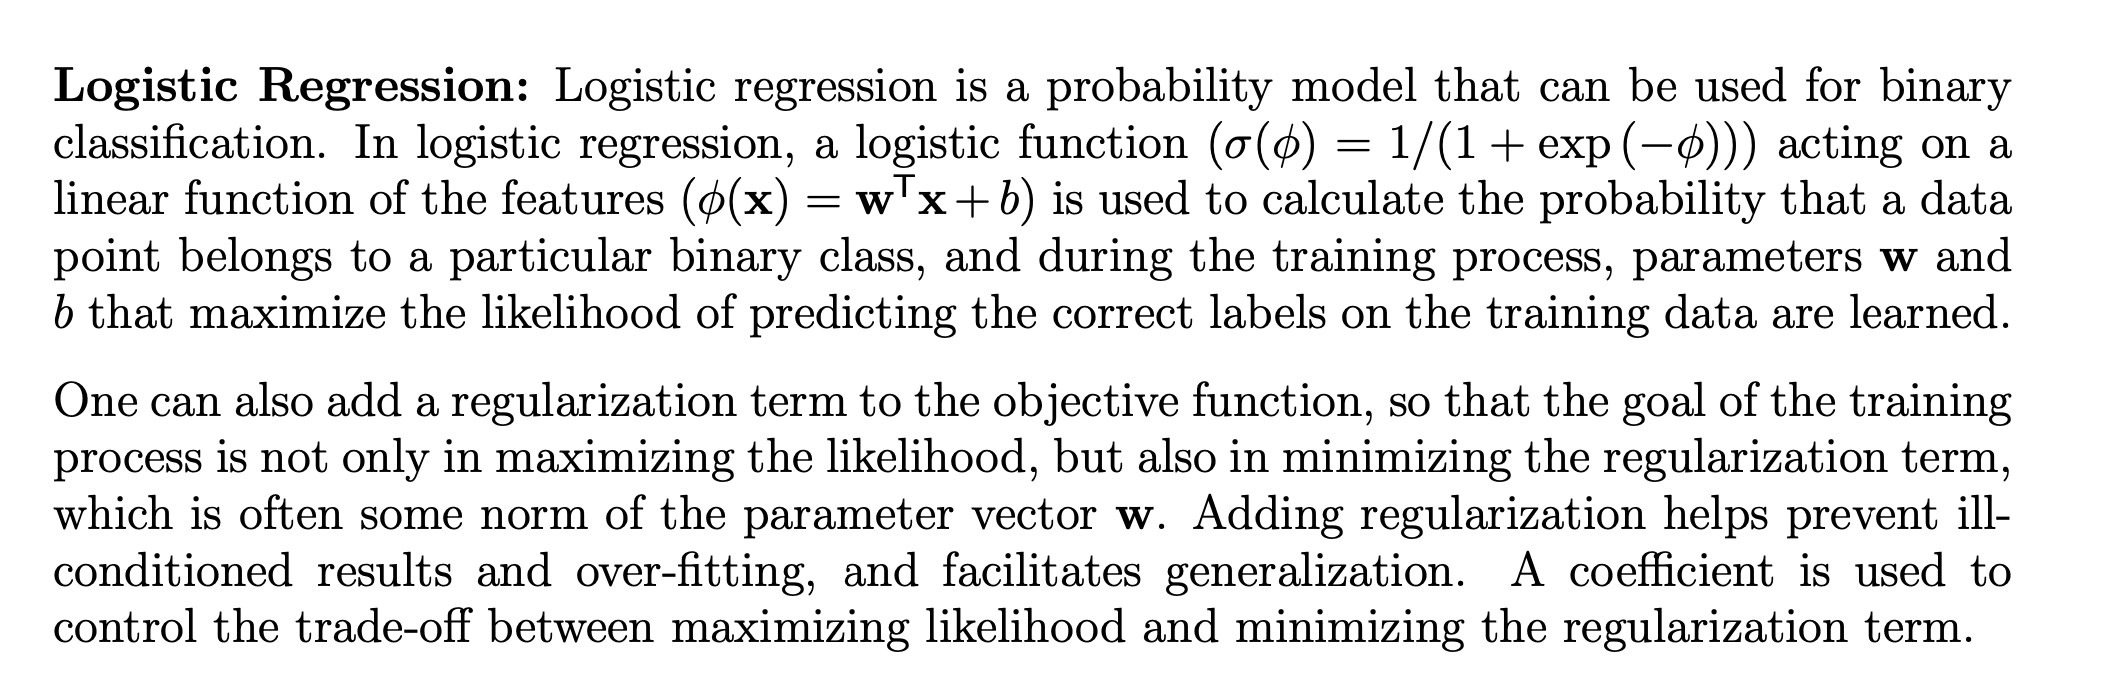

#QUESTION 6: 
Evaluate a logistic classifier:

  • Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier on the testing set.
  
  • Find the optimal regularization coefficient:

  – Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the op- timal regularization strength in the range {10k|−4 ≤ k ≤ 4,k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.
  
  – Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classi- fiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.
  
  – How does the regularization parameter affect the test error? How are the learnt coeffi- cients affected? Why might one be interested in each type of regularization?
  
  – Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?

### Training with no regularization

gamma: auto
Accuracy: 0.9710843373493976
Precision: 0.958139534883721
Recall: 0.9856459330143541
F-1 Score: 0.9716981132075472


<Figure size 432x288 with 0 Axes>

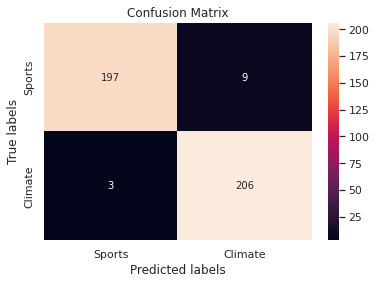

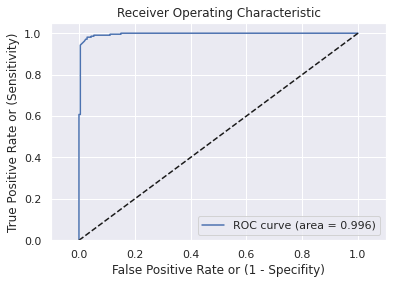

In [ ]:
# LR without a penalty term, had to increase default max iterations

from sklearn.linear_model import LogisticRegression

clf_np = LogisticRegression(random_state=0, penalty = 'none', max_iter = 500).fit(lsi_train, target_train)
predicted = clf_np.predict(lsi_test)
prob = clf_np.predict_proba(lsi_test)

perform_lr_prediction(predicted, prob, lsi_train, lsi_test, target_train, target_test, gamma='auto')

### Finding Optimal Gamma with L1 Reg. 

In [ ]:
parameters = {'C':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
clf = LogisticRegression(random_state=0, penalty = 'l1', solver='liblinear')
ls_grid = GridSearchCV(clf, parameters, cv=5)
ls_grid.fit(lsi_train, target_train)
pd.DataFrame(ls_grid.cv_results_)[['param_C','mean_test_score']]

param_C  mean_test_score
0  0.0001         0.500906
1   0.001         0.500906
2    0.01         0.500906
3     0.1         0.904639
4       1         0.955338
5      10         0.957151
6     100         0.954732
7    1000         0.952925
8   10000         0.952925

### Finding Optimal Gamma with L2 Reg. 

In [ ]:
parameters = {'C':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
clf = LogisticRegression(random_state=0, penalty = 'l2', max_iter = 1000)
ls_grid = GridSearchCV(clf, parameters, cv=5)
ls_grid.fit(lsi_train, target_train)
pd.DataFrame(ls_grid.cv_results_)[['param_C','mean_test_score']]

param_C  mean_test_score
0  0.0001         0.500906
1   0.001         0.900451
2    0.01         0.941455
3     0.1         0.945676
4       1         0.952919
5      10         0.955340
6     100         0.954131
7    1000         0.955940
8   10000         0.954131

## Comparing Results of Logistic Regression

Performance with Optimal C for L1 Penalty
gamma: auto
Accuracy: 0.9734939759036144
Precision: 0.9669811320754716
Recall: 0.9808612440191388
F-1 Score: 0.9738717339667458


<Figure size 432x288 with 0 Axes>

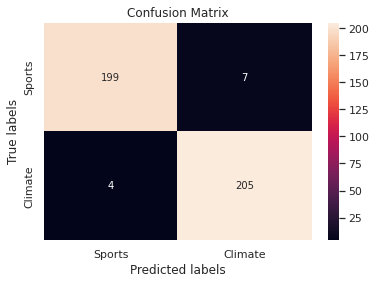

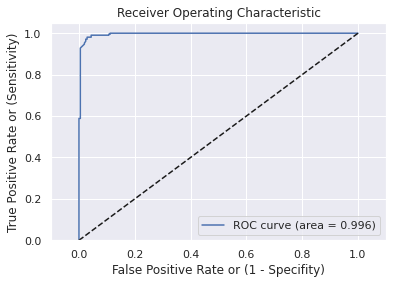

Performance with Optimal C for L2 Penalty
gamma: auto
Accuracy: 0.9710843373493976
Precision: 0.9624413145539906
Recall: 0.9808612440191388
F-1 Score: 0.9715639810426541


<Figure size 432x288 with 0 Axes>

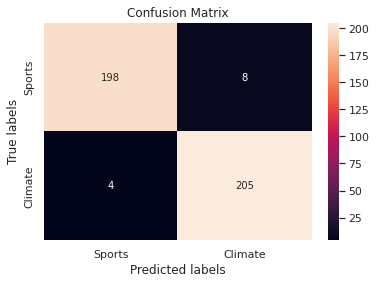

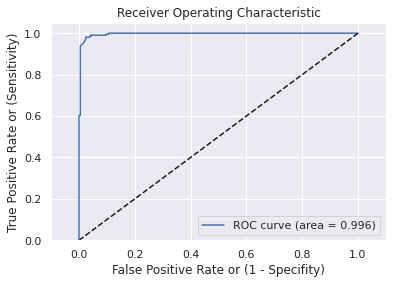

Performance with Optimal C for No Penalty
gamma: auto
Accuracy: 0.9710843373493976
Precision: 0.958139534883721
Recall: 0.9856459330143541
F-1 Score: 0.9716981132075472


<Figure size 432x288 with 0 Axes>

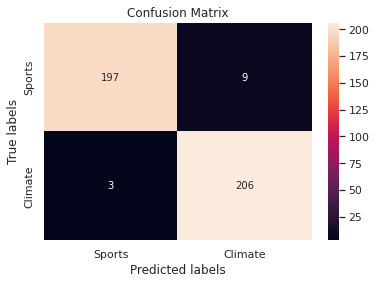

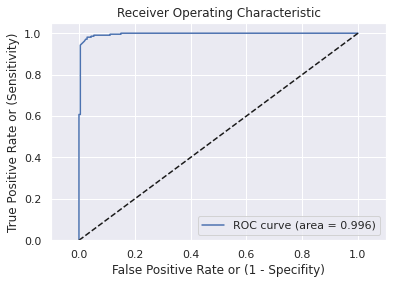

In [ ]:
# Train with Optimal C for L1
print('Performance with Optimal C for L1 Penalty')
clf_l1 = LogisticRegression(random_state=0, penalty = 'l1', solver='liblinear', C=10).fit(lsi_train, target_train)
predicted_l1 = clf_l1.predict(lsi_test)
prob1 = clf_l1.predict_proba(lsi_test)
perform_lr_prediction(predicted_l1, prob1, lsi_train, lsi_test, target_train, target_test, gamma='auto')

# Train with Optimal C for L2
print('Performance with Optimal C for L2 Penalty')
clf_l2 = LogisticRegression(random_state=0, penalty = 'l2', max_iter = 500, C=1000).fit(lsi_train, target_train)
predicted_l2 = clf_l2.predict(lsi_test)
prob2 = clf_l2.predict_proba(lsi_test)
perform_lr_prediction(predicted_l2, prob2, lsi_train, lsi_test, target_train, target_test, gamma='auto')

print('Performance with Optimal C for No Penalty')
perform_lr_prediction(predicted, prob, lsi_train, lsi_test, target_train, target_test, gamma='auto')

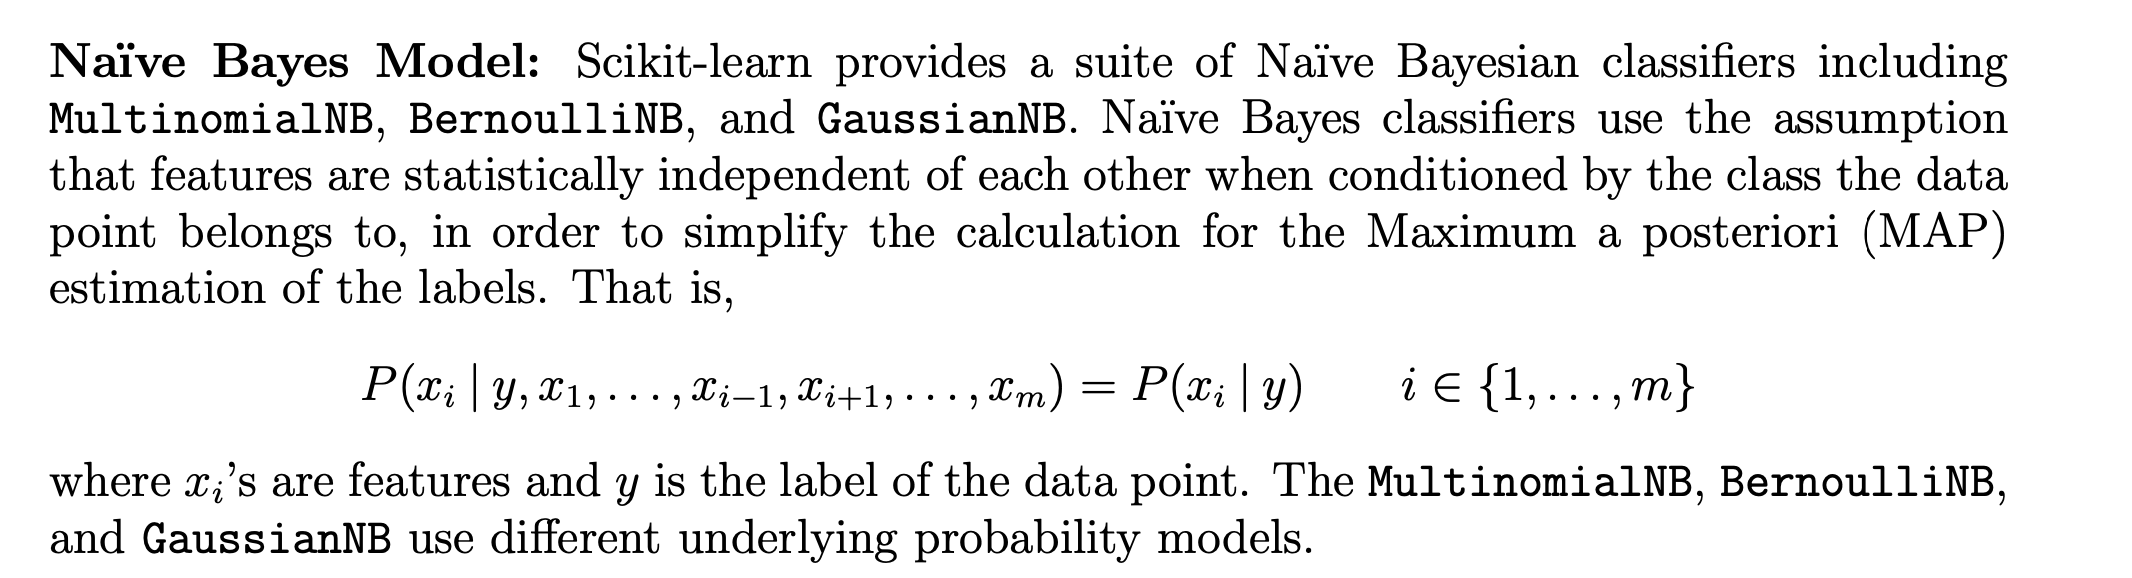

# QUESTION 7: 
Evaluate and profile a Na ̈ıve Bayes classifier: Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.

Accuracy: 0.9518072289156626
Precision: 0.9609756097560975
Recall: 0.9425837320574163
F-1 Score: 0.9516908212560385


<Figure size 432x288 with 0 Axes>

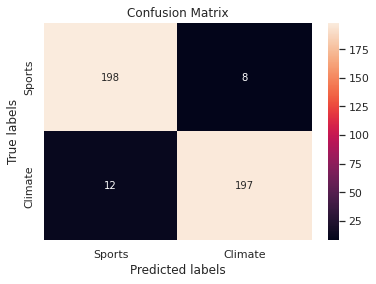

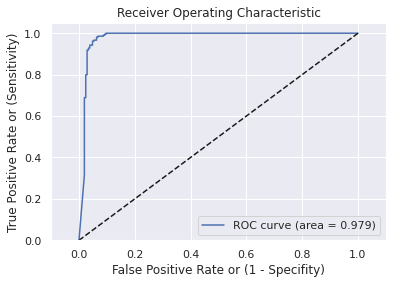

In [ ]:
perform_naive_bayes_prediction(lsi_train, lsi_test, target_train, target_test)

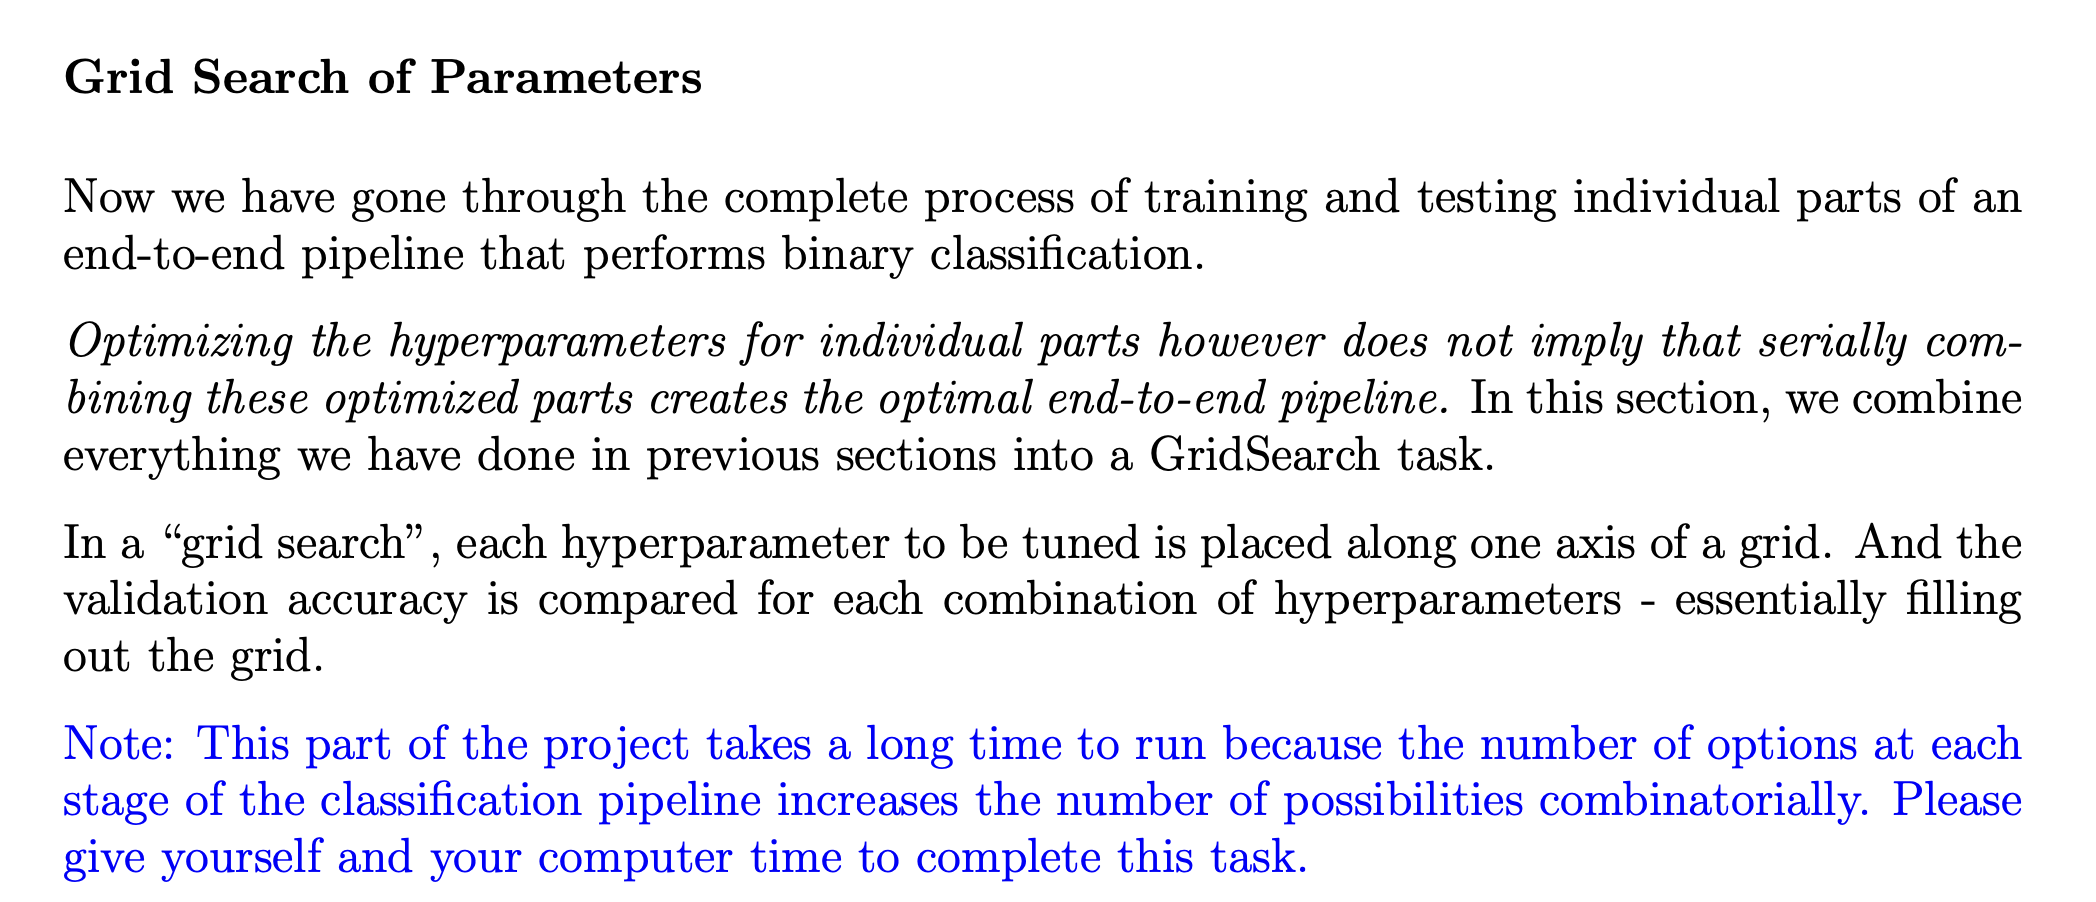

#QUESTION 8: In this part, you will attempt to find the best model for binary classification.

  • Construct a Pipeline that performs feature extraction, dimensionality reduction and classifi-
cation;

  • The evaluation of each combination is performed with 5-fold cross-validation (use the average validation set accuracy across folds).

  • In addition to any other hyperparameters you choose, your gridsearch must at least include:

In [ ]:
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

import string

def without_anything_clean(doc):
    doc = clean(doc)
    sent = nltk.word_tokenize(doc)
    sent = [i for i in sent if i not in string.punctuation]
    sent = [i for i in sent if not i.isdigit()]
    return sent

def with_stemming_clean(doc):
  doc = clean(doc)
  ps = nltk.stem.PorterStemmer()
  sent = [ps.stem(word.lower()) for word in nltk.word_tokenize(doc))]
  sent = [i for i in sent if i not in string.punctuation]
  sent = [i for i in sent if not i.isdigit()]
  return sent

def with_lemmatize_clean(doc):
  doc = clean(doc)
  wnl = nltk.wordnet.WordNetLemmatizer()
  sent = [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(nltk.word_tokenize(doc))]
  sent = [i for i in sent if i not in string.punctuation]
  sent = [i for i in sent if not i.isdigit()]
  return sent

def without_anything(doc):
    sent = nltk.word_tokenize(doc)
    sent = [i for i in sent if i not in string.punctuation]
    sent = [i for i in sent if not i.isdigit()]
    return sent

def with_stemming(doc):
  ps = nltk.stem.PorterStemmer()
  sent = [ps.stem(word.lower()) for word in nltk.word_tokenize(doc))]
  sent = [i for i in sent if i not in string.punctuation]
  sent = [i for i in sent if not i.isdigit()]
  return sent

def with_lemmatize(doc):
  wnl = nltk.wordnet.WordNetLemmatizer()
  sent = [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(nltk.word_tokenize(doc))]
  sent = [i for i in sent if i not in string.punctuation]
  sent = [i for i in sent if not i.isdigit()]
  return sent

train, test = train_test_split(news_articles[["full_text","root_label"]], test_size=0.2)

list_train = train.full_text.tolist()
target_train = train.root_label.tolist()
target_train = (train.root_label == 'sports')

list_test = test.full_text.tolist()
truth_test_labels = test.root_label.tolist()
target_test = (test.root_label == 'sports')
target_test

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([('vect',TfidfVectorizer(stop_words='english')),
                     ('reduce_dim',None),
                     ('classify',None)], memory=memory)
                     
param_grid = {
    'vect__min_df': (3,5),
    'vect__analyzer': (with_lemmatize_clean, with_stemming_clean, without_anything_clean, with_lemmatize, with_stemming, without_anything),
    'reduce_dim':(TruncatedSVD(n_components=5,random_state=42), TruncatedSVD(n_components=50,random_state=42), TruncatedSVD(n_components=200,random_state=42), NMF(n_components=5,init='random', random_state=42), NMF(n_components=50,init='random', random_state=42), NMF(n_components=200,init='random', random_state=42)),
    'classify':(svm.SVC(C = 10, probability=True, kernel='linear', random_state=42), LogisticRegression(penalty='l2',C=10,random_state=42),
                LogisticRegression(penalty='l1',C=1000,random_state=42), GaussianNB())
    } # parameter grid for the pipeline to find the best combination

grid = GridSearchCV(pipeline,cv=5,param_grid=param_grid,scoring='accuracy')

grid.fit(list_train, target_train)
print("Best score for pipeline: ", grid.best_score_)
print("Best params for pipeline: ", grid.best_params_)
print("Best estimator for pipeline: ", grid.best_estimator_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/tmp/tmpchubmwnd'", use "location='/tmp/tmpchubmwnd'" instead.


Streaming output truncated to the last 5000 lines.
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=5, random_state=42), <1325x6423 sparse matrix of type '<class 'numpy.float64'>'
	with 235356 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lemmatize_clean at 0x7fc7207270e0>,
                min_df=5, stop_words='english'), 
[ '© Provided by TechRadar A TSMC Silicon Wafer\n'
  '\n'
  'The crisis sweeping the global s

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 0.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/efce224b9c113b60a36848ef8bf044c4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1326x9501 sparse matrix of type '<class 'numpy.float64'>'
	with 243266 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 0.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/607b465393fdb93188f813fb93cad4e7
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1326x9506 sparse matrix of type '<class 'numpy.float64'>'
	with 245667 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.5s, 0.0min
[Memory]0.0s, 0.0min    : 

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 1.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/da16caa6d78d150901a82a2f2b1d8af4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1326x13670 sparse matrix of type '<class 'numpy.float64'>'
	with 276223 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 1.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/40cf05301334546f9fca566e5c2161eb
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1326x13413 sparse matrix of type '<class 'numpy.float64'>'
	with 269264 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 1.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/76bd7ea9bfffb38d9be1b021c85d4df1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1326x13394 sparse matrix of type '<class 'numpy.float64'>'
	with 271539 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.8s, 0.0min
[Memory]0.0s, 0.0min    :

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 0.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/a8f1d5f33ff3d00218663ae66914d017
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1325x8804 sparse matrix of type '<class 'numpy.float64'>'
	with 256376 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 0.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/2be9fc454829d75703d6c3fcb7f467ac
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1326x8919 sparse matrix of type '<class 'numpy.float64'>'
	with 260154 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 0.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/4c09c844708ed9f7b625c0ac4acefd40
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1326x8672 sparse matrix of type '<class 'numpy.float64'>'
	with 253310 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
[Memory]0.0s, 0.0min    : 

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 0.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/4ffb1d703785eaf4868a394aa580d544
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1325x9542 sparse matrix of type '<class 'numpy.float64'>'
	with 247274 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
[Memory]0.0s, 0.0min    : 

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 0.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/d94a61d10401513d9c84847efccd3e54
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1326x9510 sparse matrix of type '<class 'numpy.float64'>'
	with 248928 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.5s, 0.0min
[Memory]0.0s, 0.0min    : 

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 1.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/54392498468a029af9478735910e2dcf
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1326x13338 sparse matrix of type '<class 'numpy.float64'>'
	with 271890 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 1.1s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/4b52b24936e01c427da6a60f433f5499
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1326x13315 sparse matrix of type '<class 'numpy.float64'>'
	with 274217 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 1.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/151fab8d6d27669ce422f7808adeba63
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=5, random_state=42), <1325x8628 sparse matrix of type '<class 'numpy.float64'>'
	with 256860 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.7s, 0.0min
[Memory]0.0s, 0.0min    : 

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 0.9s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/08cef9dc6c4d7ae8228324a3d1cd23a9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x9538 sparse matrix of type '<class 'numpy.float64'>'
	with 244033 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.3s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/5a738da29b79cee1615dc46f8fafdfd9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x9682 sparse matrix of type '<class 'numpy.float64'>'
	with 246377 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.6s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/bcb9ac8e93e9228d2efb7c4c819045aa
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x9703 sparse matrix of type '<class 'numpy.float64'>'
	with 249247 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.6s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/efce224b9c113b60a36848ef8bf044c4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x9501 sparse matrix of type '<class 'numpy.float64'>'
	with 243266 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 9.3s, 0.2min
[Memory]0.0s, 0.0min    :

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.3s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/f37bb1263f5252d9606806edf0d926cd
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x6344 sparse matrix of type '<class 'numpy.float64'>'
	with 233224 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 8.7s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/489e56bb98dac58924a36287f9e52900
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x6423 sparse matrix of type '<class 'numpy.float64'>'
	with 235356 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 9.0s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/72d43fb5aefb655f2b19e073a8fa6d5e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x6526 sparse matrix of type '<class 'numpy.float64'>'
	with 238516 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 9.1s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/98f76df02d5d90e80cd4e5060240ca93
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x6314 sparse matrix of type '<class 'numpy.float64'>'
	with 232563 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 8.4s, 0.1min
[Memory]0.0s, 0.0min    :

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 8.9s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_stemming_clean at 0x7fc720772440>,
                min_df=3, stop_words='english'), 
[ 'The 12th Annual Sally A. Lock Coaches vs Cancer Charity Soccer Game is '
  'Saturday, October 2, 2021 at Jamesville-DeWitt High School. The 12th Annual '
  'Sally A. Lock Coaches vs Cancer Charity Soccer Game is this Saturday at '
  'Jamesville-Dewitt High School. JD Junior Varsity Boys Soccer Coach Paul '
  'Krause shares the touching story of his sister Sally and the history of '
  'this event.\n'
  '\n'
  'Last year, I raised $700. This year, my goal is to raise $1,000. Please '
  'consider making a donation of any amount to the American Cancer Society. '
  'Facebook pays all the processing fees for you, so 100% of your dona

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 15.0s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/e2a657080882f6d22d3accb25fa4ac2c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x13561 sparse matrix of type '<class 'numpy.float64'>'
	with 272461 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 15.0s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/da16caa6d78d150901a82a2f2b1d8af4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x13670 sparse matrix of type '<class 'numpy.float64'>'
	with 276223 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 15.2s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/40cf05301334546f9fca566e5c2161eb
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x13413 sparse matrix of type '<class 'numpy.float64'>'
	with 269264 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)
_______________________________________________fit_transform_one - 14.5s, 0.2min
[Memory]0.0s, 0.0min    

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 14.9s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/29dc38ccf288123b6759c4f1a8fd4bb5
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x8685 sparse matrix of type '<class 'numpy.float64'>'
	with 254094 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.1s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/a8f1d5f33ff3d00218663ae66914d017
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x8804 sparse matrix of type '<class 'numpy.float64'>'
	with 256376 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.3s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/2be9fc454829d75703d6c3fcb7f467ac
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x8919 sparse matrix of type '<class 'numpy.float64'>'
	with 260154 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.2s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/4c09c844708ed9f7b625c0ac4acefd40
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x8672 sparse matrix of type '<class 'numpy.float64'>'
	with 253310 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 10.9s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/12300af6f9d0695ffcc3cea984947e80
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x8683 sparse matrix of type '<class 'numpy.float64'>'
	with 255670 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.1s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/4ffb1d703785eaf4868a394aa580d544
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x9542 sparse matrix of type '<class 'numpy.float64'>'
	with 247274 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.1s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/57e28798c07cc0344b2e1c29a5981a2c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x9699 sparse matrix of type '<class 'numpy.float64'>'
	with 249652 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.3s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/b559d1ec57c933a82e9dc05db798b3d9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x9717 sparse matrix of type '<class 'numpy.float64'>'
	with 252521 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 9.1s, 0.2min
[Memory]0.0s, 0.0min    :

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.0s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/d94a61d10401513d9c84847efccd3e54
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x9510 sparse matrix of type '<class 'numpy.float64'>'
	with 248928 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 10.4s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/517c843965619e39b7722043fa1ae578
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x6344 sparse matrix of type '<class 'numpy.float64'>'
	with 236462 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 8.4s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/9cd70069566ad0a1cc84b16897d77de5
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x6404 sparse matrix of type '<class 'numpy.float64'>'
	with 238498 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 8.6s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/71408576e187a45318a98d551495d8a4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x6517 sparse matrix of type '<class 'numpy.float64'>'
	with 241713 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 8.5s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/556cf736f8cfc5f18413e11eefb22637
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x6311 sparse matrix of type '<class 'numpy.float64'>'
	with 235714 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 8.8s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/928bea5a9e63c7a6600fe05994b1f00e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x6347 sparse matrix of type '<class 'numpy.float64'>'
	with 238269 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 8.9s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_stemming at 0x7fc7207275f0>, min_df=3,
                stop_words='english'), 
[ 'The 12th Annual Sally A. Lock Coaches vs Cancer Charity Soccer Game is '
  'Saturday, October 2, 2021 at Jamesville-DeWitt High School. The 12th Annual '
  'Sally A. Lock Coaches vs Cancer Charity Soccer Game is this Saturday at '
  'Jamesville-Dewitt High School. JD Junior Varsity Boys Soccer Coach Paul '
  'Krause shares the touching story of his sister Sally and the history of '
  'this event.\n'
  '\n'
  'Last year, I raised $700. This year, my goal is to raise $1,000. Please '
  'consider making a donation of any amount to the American Cancer Society. '
  'Facebook pays all the processing fees for you, so 100% of your donation '

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 15.0s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/f2f3d8750c4abc6df2e442a10449cbee
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x13590 sparse matrix of type '<class 'numpy.float64'>'
	with 278866 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 15.1s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/54392498468a029af9478735910e2dcf
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x13338 sparse matrix of type '<class 'numpy.float64'>'
	with 271890 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 14.9s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/4b52b24936e01c427da6a60f433f5499
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x13315 sparse matrix of type '<class 'numpy.float64'>'
	with 274217 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 14.8s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/151fab8d6d27669ce422f7808adeba63
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x8628 sparse matrix of type '<class 'numpy.float64'>'
	with 256860 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 10.9s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/2a85059939cb114ec00d47f908fd014c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x8728 sparse matrix of type '<class 'numpy.float64'>'
	with 259013 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.1s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/4a0750a44c55d9fbeebdfee493faefd1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x8852 sparse matrix of type '<class 'numpy.float64'>'
	with 262853 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 8.7s, 0.1min
[Memory]0.0s, 0.0min    :

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 10.8s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/e8e1623467005a2896a5b9b58e840cf4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x8611 sparse matrix of type '<class 'numpy.float64'>'
	with 258383 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 11.0s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/08cef9dc6c4d7ae8228324a3d1cd23a9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x9538 sparse matrix of type '<class 'numpy.float64'>'
	with 244033 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 163.0s, 2.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/5a738da29b79cee1615dc46f8fafdfd9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x9682 sparse matrix of type '<class 'numpy.float64'>'
	with 246377 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 163.0s, 2.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/bcb9ac8e93e9228d2efb7c4c819045aa
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x9703 sparse matrix of type '<class 'numpy.float64'>'
	with 249247 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 163.7s, 2.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/efce224b9c113b60a36848ef8bf044c4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x9501 sparse matrix of type '<class 'numpy.float64'>'
	with 243266 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 152.3s, 2.5min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/607b465393fdb93188f813fb93cad4e7
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x9506 sparse matrix of type '<class 'numpy.float64'>'
	with 245667 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 160.3s, 2.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/f37bb1263f5252d9606806edf0d926cd
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x6344 sparse matrix of type '<class 'numpy.float64'>'
	with 233224 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 112.0s, 1.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/489e56bb98dac58924a36287f9e52900
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x6423 sparse matrix of type '<class 'numpy.float64'>'
	with 235356 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 113.3s, 1.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/72d43fb5aefb655f2b19e073a8fa6d5e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x6526 sparse matrix of type '<class 'numpy.float64'>'
	with 238516 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 114.4s, 1.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/98f76df02d5d90e80cd4e5060240ca93
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x6314 sparse matrix of type '<class 'numpy.float64'>'
	with 232563 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 111.5s, 1.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/46fcf475428c0d06a211fefedd792e60
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x6366 sparse matrix of type '<class 'numpy.float64'>'
	with 235096 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 110.8s, 1.8min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_stemming_clean at 0x7fc720772440>,
                min_df=3, stop_words='english'), 
[ 'The 12th Annual Sally A. Lock Coaches vs Cancer Charity Soccer Game is '
  'Saturday, October 2, 2021 at Jamesville-DeWitt High School. The 12th Annual '
  'Sally A. Lock Coaches vs Cancer Charity Soccer Game is this Saturday at '
  'Jamesville-Dewitt High School. JD Junior Varsity Boys Soccer Coach Paul '
  'Krause shares the touching story of his sister Sally and the history of '
  'this event.\n'
  '\n'
  'Last year, I raised $700. This year, my goal is to raise $1,000. Please '
  'consider making a donation of any amount to the American Cancer Society. '
  'Facebook pays all the processing fees for you, so 100% of your dona

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 220.8s, 3.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/e2a657080882f6d22d3accb25fa4ac2c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x13561 sparse matrix of type '<class 'numpy.float64'>'
	with 272461 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 221.2s, 3.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/da16caa6d78d150901a82a2f2b1d8af4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x13670 sparse matrix of type '<class 'numpy.float64'>'
	with 276223 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 223.7s, 3.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/40cf05301334546f9fca566e5c2161eb
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x13413 sparse matrix of type '<class 'numpy.float64'>'
	with 269264 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 214.2s, 3.6min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/76bd7ea9bfffb38d9be1b021c85d4df1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x13394 sparse matrix of type '<class 'numpy.float64'>'
	with 271539 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 218.5s, 3.6min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/29dc38ccf288123b6759c4f1a8fd4bb5
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x8685 sparse matrix of type '<class 'numpy.float64'>'
	with 254094 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 145.5s, 2.4min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/a8f1d5f33ff3d00218663ae66914d017
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x8804 sparse matrix of type '<class 'numpy.float64'>'
	with 256376 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 146.0s, 2.4min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/2be9fc454829d75703d6c3fcb7f467ac
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x8919 sparse matrix of type '<class 'numpy.float64'>'
	with 260154 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 148.9s, 2.5min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/4c09c844708ed9f7b625c0ac4acefd40
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x8672 sparse matrix of type '<class 'numpy.float64'>'
	with 253310 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 141.2s, 2.4min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/12300af6f9d0695ffcc3cea984947e80
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x8683 sparse matrix of type '<class 'numpy.float64'>'
	with 255670 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 146.1s, 2.4min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/4ffb1d703785eaf4868a394aa580d544
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x9542 sparse matrix of type '<class 'numpy.float64'>'
	with 247274 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 157.4s, 2.6min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/57e28798c07cc0344b2e1c29a5981a2c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x9699 sparse matrix of type '<class 'numpy.float64'>'
	with 249652 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 159.8s, 2.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/b559d1ec57c933a82e9dc05db798b3d9
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x9717 sparse matrix of type '<class 'numpy.float64'>'
	with 252521 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 161.0s, 2.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/64229fd0d948d9509cfff9deb7d2dd70
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x9510 sparse matrix of type '<class 'numpy.float64'>'
	with 246461 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 152.1s, 2.5min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/d94a61d10401513d9c84847efccd3e54
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x9510 sparse matrix of type '<class 'numpy.float64'>'
	with 248928 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 157.9s, 2.6min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/517c843965619e39b7722043fa1ae578
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x6344 sparse matrix of type '<class 'numpy.float64'>'
	with 236462 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 111.7s, 1.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/9cd70069566ad0a1cc84b16897d77de5
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x6404 sparse matrix of type '<class 'numpy.float64'>'
	with 238498 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 113.5s, 1.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/71408576e187a45318a98d551495d8a4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x6517 sparse matrix of type '<class 'numpy.float64'>'
	with 241713 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 115.1s, 1.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/556cf736f8cfc5f18413e11eefb22637
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x6311 sparse matrix of type '<class 'numpy.float64'>'
	with 235714 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 109.4s, 1.8min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/928bea5a9e63c7a6600fe05994b1f00e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x6347 sparse matrix of type '<class 'numpy.float64'>'
	with 238269 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 110.4s, 1.8min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_stemming at 0x7fc7207275f0>, min_df=3,
                stop_words='english'), 
[ 'The 12th Annual Sally A. Lock Coaches vs Cancer Charity Soccer Game is '
  'Saturday, October 2, 2021 at Jamesville-DeWitt High School. The 12th Annual '
  'Sally A. Lock Coaches vs Cancer Charity Soccer Game is this Saturday at '
  'Jamesville-Dewitt High School. JD Junior Varsity Boys Soccer Coach Paul '
  'Krause shares the touching story of his sister Sally and the history of '
  'this event.\n'
  '\n'
  'Last year, I raised $700. This year, my goal is to raise $1,000. Please '
  'consider making a donation of any amount to the American Cancer Society. '
  'Facebook pays all the processing fees for you, so 100% of your donation '

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 217.1s, 3.6min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/1afafa9adbd5897d5656c11f5e4aa224
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x13496 sparse matrix of type '<class 'numpy.float64'>'
	with 275127 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 220.5s, 3.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/f2f3d8750c4abc6df2e442a10449cbee
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x13590 sparse matrix of type '<class 'numpy.float64'>'
	with 278866 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 221.3s, 3.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/54392498468a029af9478735910e2dcf
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x13338 sparse matrix of type '<class 'numpy.float64'>'
	with 271890 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 209.4s, 3.5min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/4b52b24936e01c427da6a60f433f5499
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x13315 sparse matrix of type '<class 'numpy.float64'>'
	with 274217 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 216.2s, 3.6min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/151fab8d6d27669ce422f7808adeba63
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x8628 sparse matrix of type '<class 'numpy.float64'>'
	with 256860 stored elements in Compressed Sparse Row format>, 
654      True
1498    False
1737    False
1006     True
2022    False
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 144.5s, 2.4min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/2a85059939cb114ec00d47f908fd014c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1325x8728 sparse matrix of type '<class 'numpy.float64'>'
	with 259013 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1325, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 146.2s, 2.4min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/4a0750a44c55d9fbeebdfee493faefd1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x8852 sparse matrix of type '<class 'numpy.float64'>'
	with 262853 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 147.1s, 2.5min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/39ada0d94d303724c8992b2b8a4b501f
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x8614 sparse matrix of type '<class 'numpy.float64'>'
	with 256002 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
1999    False
1310    False
1987    False
813      True
344      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


______________________________________________fit_transform_one - 138.7s, 2.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpchubmwnd/joblib/sklearn/pipeline/_fit_transform_one/e8e1623467005a2896a5b9b58e840cf4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=200, random_state=42), <1326x8611 sparse matrix of type '<class 'numpy.float64'>'
	with 258383 stored elements in Compressed Sparse Row format>, 
1872    False
1882    False
1342    False
511      True
698      True
        ...  
459      True
783      True
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Streaming output truncated to the last 5000 lines.
1012     True
1184    False
799      True
Name: root_label, Length: 1326, dtype: bool, 
None, message_clsname='Pipeline', message=None)
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_stemming_clean at 0x7fc720772440>,
                min_df=5, stop_words='english'), 
[ 'The 12th Annual Sally A. Lock Coaches vs Cancer Charity Soccer Game is '
  'Saturday, October 2, 2021 at Jamesville-DeWitt High School. The 12th Annual '
  'Sally A. Lock Coaches vs Cancer Charity Soccer Game is this Saturday at '
  'Jamesville-Dewitt High School. JD Junior Varsity Boys Soccer Coach Paul '
  'Krause shares the touching story of his sister Sally and the history of '
  'this event.\n'
  '\n'
  'Last year, I raised $700. This year, my goal is to raise $1,000. Please '
  'consider making a donation of any amoun

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
720 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 355, in _fit
    **fit_params_steps[name],
  File "/usr/local/lib/python3.7/dist-packages/joblib/memory.py", 

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer=<function with_lemmatize_clean at 0x7fc7207270e0>,
                min_df=5, stop_words='english'), 
[ '© Provided by TechRadar A TSMC Silicon Wafer\n'
  '\n'
  'The crisis sweeping the global semiconductor industry is enormous. With the '
  'tech world totally dependent on chips, the problem has become fundamental, '
  'and worse, nobody knows when it will end. And India, which is trying to '
  'push itself into the forefront of the tech manufacturing, is also facing '
  'the pinch acutely. India, which is dependent on imports for all its chip '
  'needs, is now trying to address the problem holistically.\n'
  '\n'
  'According to a report in the Times of India, the Indian government has '
  'sounded out top chip-making companies like the TSMC (Taiwan Semiconductor '
  'Manufacturing Compa..., 
1872    Fals

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


## Training with Optimal Grid Parameters

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


NMF train:
(1657, 200)
NMF test:
(415, 200)

Accuracy: 0.9710843373493976
Precision: 0.9712918660287081
Recall: 0.9712918660287081
F-1 Score: 0.9712918660287081


<Figure size 432x288 with 0 Axes>

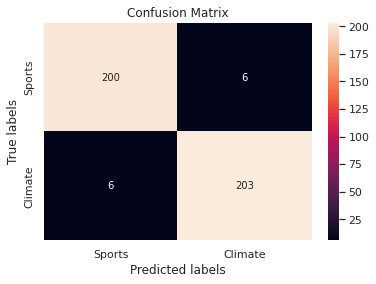

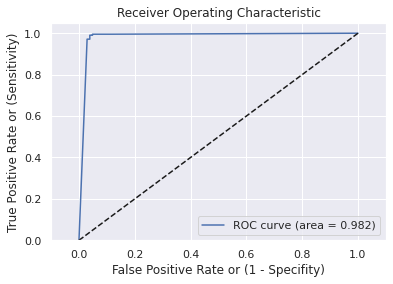

In [ ]:
# Best Combinations
# 1. GaussianNB()
# 2. NMF, nComp = 200
# 3. TF Vectorizers, lemmatize and cleaning, min_df = 5

train, test = train_test_split(news_articles[["full_text","root_label"]], test_size=0.2)

list_train = train.full_text.tolist()
target_train = train.root_label.tolist()
target_train = (train.root_label == 'sports')

list_test = test.full_text.tolist()
truth_test_labels = test.root_label.tolist()
target_test = (test.root_label == 'sports')

tf_idf = TfidfVectorizer(min_df = 5, analyzer = with_lemmatize_clean, stop_words='english')
X_train_tfidf = tf_idf.fit_transform(list_train, target_train)
X_test_tfidf = tf_idf.transform(list_test)

nmf = NMF(init='random', n_components=200, random_state=42)
nmf_train = nmf.fit_transform(X_train_tfidf)
nmf_test = nmf.transform(X_test_tfidf)
print('NMF train:')
print(nmf_train.shape)
print('NMF test:')
print(nmf_test.shape)
print('')

perform_naive_bayes_prediction(nmf_train, nmf_test, target_train, target_test)

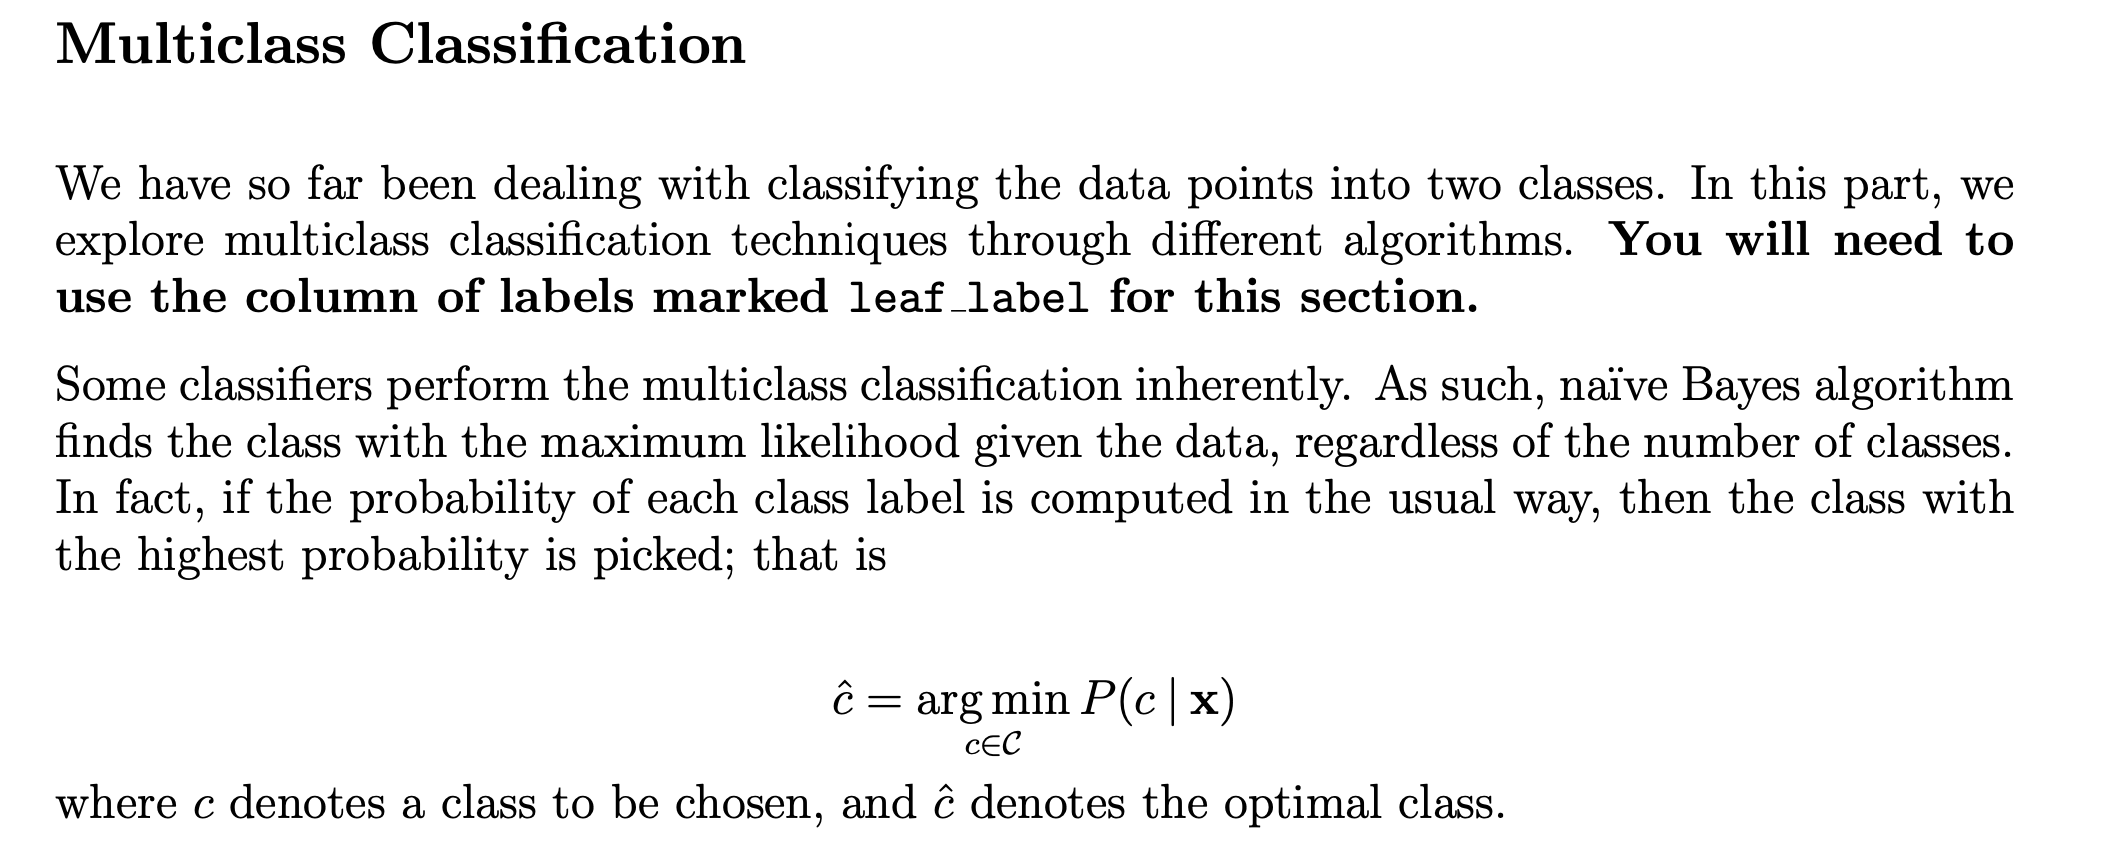

#QUESTION 9: 
In this part, we aim to learn classifiers on the documents belonging to unique classes in the column leaf label.

Perform Na ̈ıve Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above) and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class imbalance issue in the One VS the rest model?
In addition, answer the following questions:

  • In the confusion matrix you should have an 8 × 8 matrix where 8 is the number of unique labels in the column leaf label. Please make sure that the order of these labels is as follows:
Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?

  • Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix. How did the accuracy change in One VS One and One VS the rest?

  • Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest?.
    
     map_row_to_class = {0:"chess", 1:"cricket", 2:"soccer", 3:"football", 􏰀→ 4:"%22forest%20fire%22", 5:"flood", 6:"earthquake", 7:"drought"}

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(news_articles[["full_text","leaf_label"]], test_size=0.2)
print(np.shape(train))
print(np.shape(test))

list_train = train.full_text.tolist()
list_train = [clean(doc) for doc in list_train]
target_train = train.leaf_label.tolist()

list_test = test.full_text.tolist()
list_test = [clean(doc) for doc in list_test]
target_test = test.leaf_label.tolist()
target_test[0:5]

(1657, 2)
(415, 2)


['drought', '%22forest%20fire%22', 'flood', 'chess', 'football']

In [ ]:
import time

t1 = time.time()
print("Lemmatizing training set")
train_dataset_lemmatized = []
for item in list_train:
    train_dataset_lemmatized.append(' '.join(lemmatize_parse(item)))
print("Completed lemmatization of training set in %f sec\n" %(time.time()-t1))
print(len(train_dataset_lemmatized))

t1 = time.time()
print("Lemmatizing test set")
test_dataset_lemmatized = []
for item in list_test:
    test_dataset_lemmatized.append(' '.join(lemmatize_parse(item)))
print("Completed lemmatization of testing set in %f sec\n" %(time.time()-t1))
print(len(test_dataset_lemmatized))

Lemmatizing training set
Completed lemmatization of training set in 42.208533 sec

1657
Lemmatizing test set
Completed lemmatization of testing set in 10.462434 sec

415


In [ ]:
# vectorize data
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_train_counts = vectorizer.fit_transform(train_dataset_lemmatized)
X_test_counts = vectorizer.transform(test_dataset_lemmatized)
print(X_train_counts.shape)
print(X_test_counts.shape)

# generate TFxIDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# using LSI
lsi = TruncatedSVD(n_components = 50,n_iter = 10, random_state = 42)
lsi_train = lsi.fit_transform(X_train_tfidf)
lsi_test = lsi.transform(X_test_tfidf)
print('LSI train:')
print(lsi_train.shape)
print('LSI test:')
print(lsi_test.shape)
print('')

(1657, 10278)
(415, 10278)
LSI train:
(1657, 50)
LSI test:
(415, 50)



## Gaussian Naive Bayes

Accuracy: 0.8626506024096385
Precision: 0.8721138789554737
Recall: 0.863125982643654
F-1 Score: 0.8628903850363399


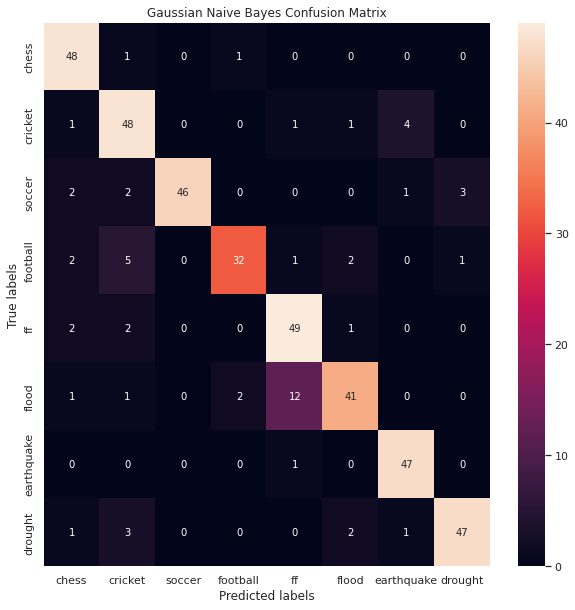

In [ ]:
%matplotlib inline

map_row_to_class = {0:"chess", 1:"cricket", 2:"soccer", 3:"football", 4:"ff", 5:"flood", 6:"earthquake", 7:"drought"}

multi_gnb = GaussianNB()
y_pred_gnb = multi_gnb.fit(lsi_train,target_train).predict(lsi_test) # training multiclass Gaussian Naive Bayes model

prob = multi_gnb.predict_proba(lsi_test)

print('Accuracy: ' + str(metrics.accuracy_score(np.asarray(target_test).ravel(), y_pred_gnb)))
print('Precision: ' + str(metrics.precision_score(np.asarray(target_test).ravel(), y_pred_gnb, average='macro')))
print('Recall: ' + str(metrics.recall_score(np.asarray(target_test).ravel(), y_pred_gnb, average='macro')))
print('F-1 Score: ' + str(metrics.f1_score(np.asarray(target_test).ravel(), y_pred_gnb, average='macro')))
    
#compute confusion matrix
cm = metrics.confusion_matrix(target_test, y_pred_gnb)

# Plot confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix_multi(cm, map_row_to_class.values() )
plt.title('Gaussian Naive Bayes Confusion Matrix')
plt.show() 

## One vs One and One vs Rest

Accuracy: 0.8987951807228916
Precision: 0.918222561906944
Recall: 0.9001703927277673
F-1 Score: 0.9040864951056242


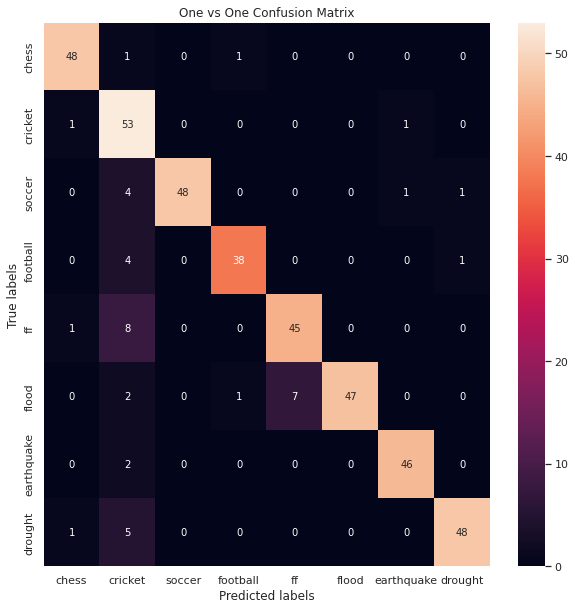

In [ ]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

svm_one = OneVsOneClassifier(SVC(random_state=42))
y_pred_one = svm_one.fit(lsi_train, target_train).predict(lsi_test)

print('Accuracy: ' + str(metrics.accuracy_score(np.asarray(target_test).ravel(), y_pred_one)))
print('Precision: ' + str(metrics.precision_score(np.asarray(target_test).ravel(), y_pred_one, average='macro')))
print('Recall: ' + str(metrics.recall_score(np.asarray(target_test).ravel(), y_pred_one, average='macro')))
print('F-1 Score: ' + str(metrics.f1_score(np.asarray(target_test).ravel(), y_pred_one, average='macro')))
    
#compute confusion matrix
cm = metrics.confusion_matrix(target_test, y_pred_one)
# Plot confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix_multi(cm, map_row_to_class.values() )
plt.title('One vs One Confusion Matrix')
plt.show() 

Accuracy: 0.9204819277108434
Precision: 0.9230921238642191
Recall: 0.9223223424061092
F-1 Score: 0.9219843041948537


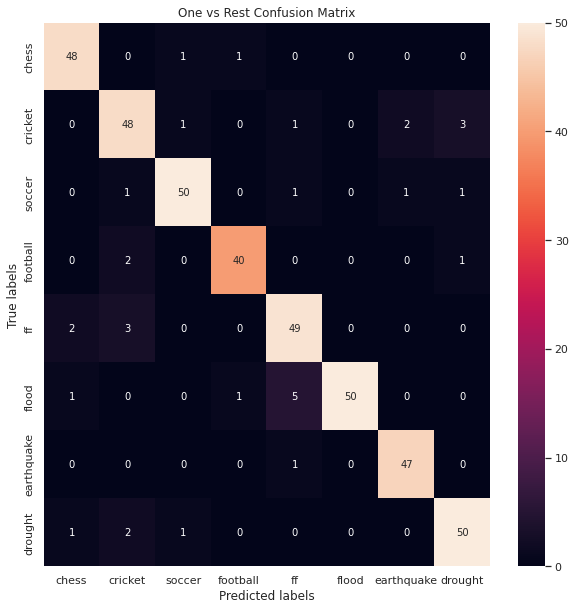

In [ ]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

svm_rest = OneVsRestClassifier(SVC(random_state=42))
y_pred_rest = svm_rest.fit(lsi_train, target_train).predict(lsi_test)

print('Accuracy: ' + str(metrics.accuracy_score(np.asarray(target_test).ravel(), y_pred_rest)))
print('Precision: ' + str(metrics.precision_score(np.asarray(target_test).ravel(), y_pred_rest, average='macro')))
print('Recall: ' + str(metrics.recall_score(np.asarray(target_test).ravel(), y_pred_rest, average='macro')))
print('F-1 Score: ' + str(metrics.f1_score(np.asarray(target_test).ravel(), y_pred_rest, average='macro')))
    
#compute confusion matrix
cm = metrics.confusion_matrix(target_test, y_pred_rest)

# Plot confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix_multi(cm, map_row_to_class.values() )
plt.title('One vs Rest Confusion Matrix')
plt.show() 

## Merging Labels Together and Retrain

In [ ]:
from sklearn.model_selection import train_test_split
import time

combined_label = "ff+flood"

map_row_to_class = {0:"chess", 1:"cricket", 2:"soccer", 3: "football", 4:"ff+flood", 5:"earthquake", 6:"drought"}

list_full_text = news_articles["full_text"].tolist()
list_full_text = [clean(doc) for doc in list_full_text]


target = news_articles["leaf_label"].tolist()

def _replaceitem(x):
    if x == 'flood':
        return combined_label
    elif x == '%22forest%20fire%22':
       return combined_label
    else:
        return x


target = list(map(_replaceitem, target))

df = pd.DataFrame(list(zip(list_full_text, target)),
               columns =['full_text', 'leaf_label_merged'])

train, test = train_test_split(df[["full_text","leaf_label_merged"]], test_size=0.2)

list_train = train.full_text.tolist()
list_train = [clean(doc) for doc in list_train]
target_train = train.leaf_label_merged.tolist()

list_test = test.full_text.tolist()
list_test = [clean(doc) for doc in list_test]
target_test = test.leaf_label_merged.tolist()

t1 = time.time()
print("Lemmatizing training set")
train_dataset_lemmatized = []
for item in list_train:
    train_dataset_lemmatized.append(' '.join(lemmatize_parse(item)))
print("Completed lemmatization of training set in %f sec\n" %(time.time()-t1))
print(len(train_dataset_lemmatized))

t1 = time.time()
print("Lemmatizing test set")
test_dataset_lemmatized = []
for item in list_test:
    test_dataset_lemmatized.append(' '.join(lemmatize_parse(item)))
print("Completed lemmatization of testing set in %f sec\n" %(time.time()-t1))
print(len(test_dataset_lemmatized))

# vectorize data
X_train_counts = vectorizer.fit_transform(train_dataset_lemmatized)
X_test_counts = vectorizer.transform(test_dataset_lemmatized)
print(X_train_counts.shape)
print(X_test_counts.shape)

# generate TFxIDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# using LSI
lsi = TruncatedSVD(n_components = 50,n_iter = 10, random_state = 42)
lsi_train = lsi.fit_transform(X_train_tfidf)
lsi_test = lsi.transform(X_test_tfidf)
print('LSI train:')
print(lsi_train.shape)
print('LSI test:')
print(lsi_test.shape)
print('')

Lemmatizing training set
Completed lemmatization of training set in 57.482099 sec

1657
Lemmatizing test set
Completed lemmatization of testing set in 26.386475 sec

415
(1657, 10545)
(415, 10545)
LSI train:
(1657, 50)
LSI test:
(415, 50)



Accuracy: 0.8433734939759037
Precision: 0.857914362526193
Recall: 0.8560819731586532
F-1 Score: 0.850001551119448


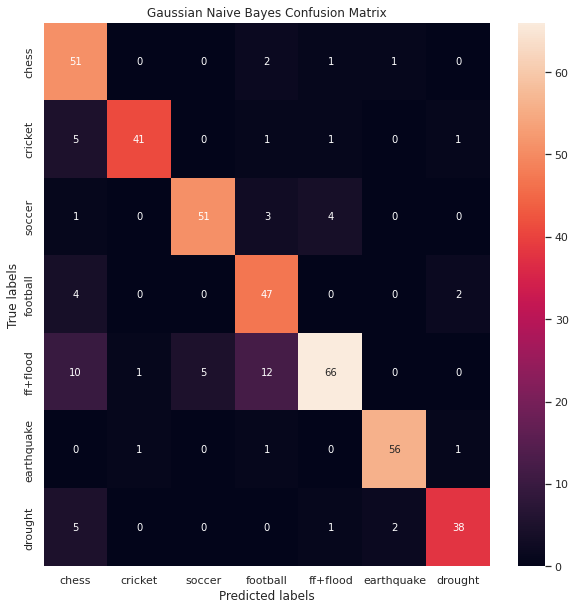

Accuracy: 0.9036144578313253
Precision: 0.9210246464241936
Recall: 0.9055599527316972
F-1 Score: 0.9116467699756676


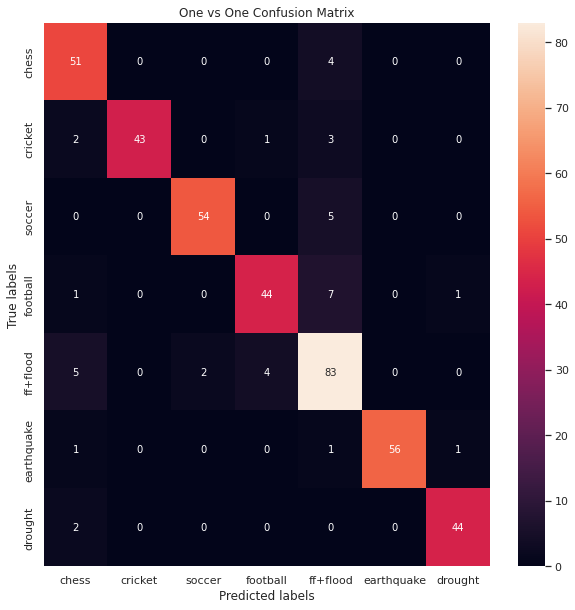

Accuracy: 0.9204819277108434
Precision: 0.9259741078494806
Recall: 0.9253220567568633
F-1 Score: 0.925481369586473


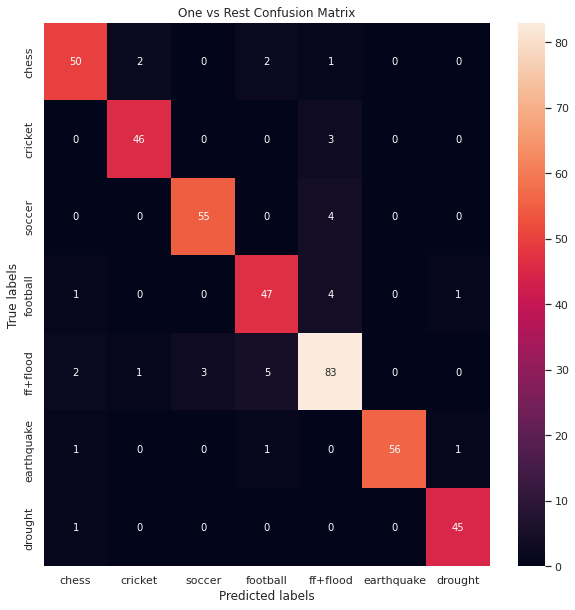

In [ ]:
# Confused labels were combined
%matplotlib inline

y_pred_gnb = multi_gnb.fit(lsi_train,target_train).predict(lsi_test) # training multiclass Gaussian Naive Bayes model

prob = multi_gnb.predict_proba(lsi_test)

print('Accuracy: ' + str(metrics.accuracy_score(np.asarray(target_test).ravel(), y_pred_gnb)))
print('Precision: ' + str(metrics.precision_score(np.asarray(target_test).ravel(), y_pred_gnb, average='macro')))
print('Recall: ' + str(metrics.recall_score(np.asarray(target_test).ravel(), y_pred_gnb, average='macro')))
print('F-1 Score: ' + str(metrics.f1_score(np.asarray(target_test).ravel(), y_pred_gnb, average='macro')))
    
#compute confusion matrix
cm = metrics.confusion_matrix(target_test, y_pred_gnb)

# Plot confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix_multi(cm, map_row_to_class.values() )
plt.title('Gaussian Naive Bayes Confusion Matrix')
plt.show()

y_pred_one = svm_one.fit(lsi_train, target_train).predict(lsi_test)

print('Accuracy: ' + str(metrics.accuracy_score(np.asarray(target_test).ravel(), y_pred_one)))
print('Precision: ' + str(metrics.precision_score(np.asarray(target_test).ravel(), y_pred_one, average='macro')))
print('Recall: ' + str(metrics.recall_score(np.asarray(target_test).ravel(), y_pred_one, average='macro')))
print('F-1 Score: ' + str(metrics.f1_score(np.asarray(target_test).ravel(), y_pred_one, average='macro')))
    
#compute confusion matrix
cm = metrics.confusion_matrix(target_test, y_pred_one)

# Plot confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix_multi(cm, map_row_to_class.values() )
plt.title('One vs One Confusion Matrix')
plt.show() 

y_pred_rest = svm_rest.fit(lsi_train, target_train).predict(lsi_test)

print('Accuracy: ' + str(metrics.accuracy_score(np.asarray(target_test).ravel(), y_pred_rest)))
print('Precision: ' + str(metrics.precision_score(np.asarray(target_test).ravel(), y_pred_rest, average='macro')))
print('Recall: ' + str(metrics.recall_score(np.asarray(target_test).ravel(), y_pred_rest, average='macro')))
print('F-1 Score: ' + str(metrics.f1_score(np.asarray(target_test).ravel(), y_pred_rest, average='macro')))
    
#compute confusion matrix
cm = metrics.confusion_matrix(target_test, y_pred_rest)

# Plot confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix_multi(cm, map_row_to_class.values() )
plt.title('One vs Rest Confusion Matrix')
plt.show() 

In [ ]:
pd.Series(target_test).value_counts()

ff+flood      94
drought       59
football      59
chess         55
earthquake    53
cricket       49
soccer        46
dtype: int64

## Undersampling the majority class to fix class imbalance issues

Counter({'ff+flood': 424, 'soccer': 213, 'cricket': 210, 'earthquake': 206, 'chess': 204, 'football': 200, 'drought': 200})
Counter({'chess': 200, 'cricket': 200, 'drought': 200, 'earthquake': 200, 'ff+flood': 200, 'football': 200, 'soccer': 200})
Accuracy: 0.908433734939759
Precision: 0.920033802758292
Recall: 0.9173825219771354
F-1 Score: 0.9145375963316854


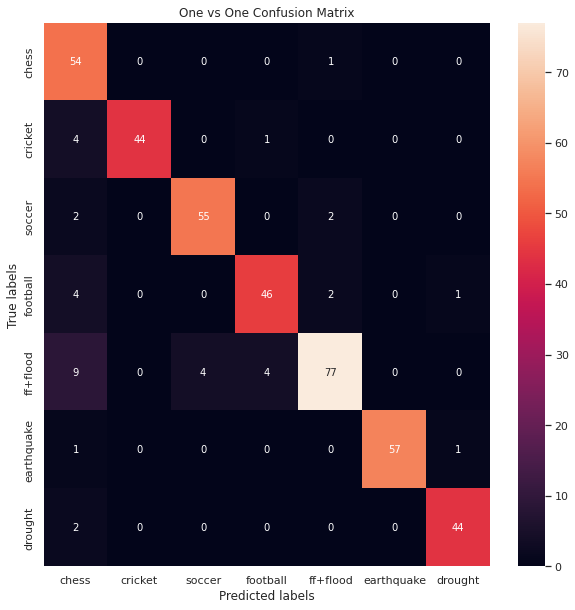

Accuracy: 0.9204819277108434
Precision: 0.9217263870026094
Recall: 0.9273451921964445
F-1 Score: 0.9241473049446858


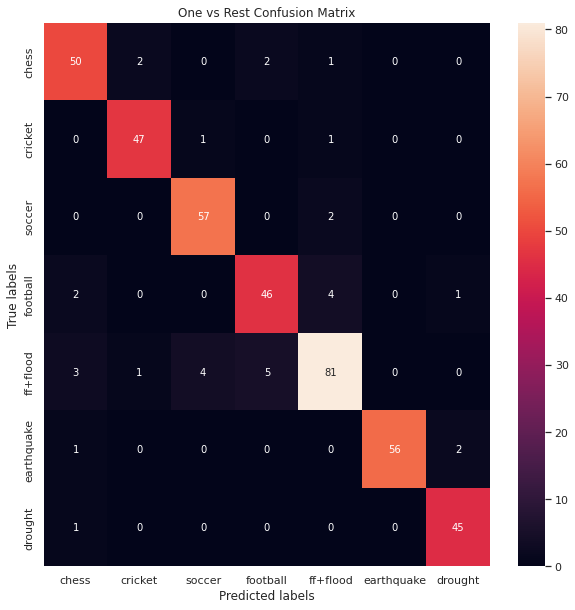

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# old class distribution
print(Counter(target_train))
rus = RandomUnderSampler() 
# resampling X, y
lsi_train_rus, target_train_rus = rus.fit_resample(lsi_train, target_train)
# new class distribution
print(Counter(target_train_rus))

y_pred_one = svm_one.fit(lsi_train_rus, target_train_rus).predict(lsi_test)

print('Accuracy: ' + str(metrics.accuracy_score(np.asarray(target_test).ravel(), y_pred_one)))
print('Precision: ' + str(metrics.precision_score(np.asarray(target_test).ravel(), y_pred_one, average='macro')))
print('Recall: ' + str(metrics.recall_score(np.asarray(target_test).ravel(), y_pred_one, average='macro')))
print('F-1 Score: ' + str(metrics.f1_score(np.asarray(target_test).ravel(), y_pred_one, average='macro')))
    
#compute confusion matrix
cm = metrics.confusion_matrix(target_test, y_pred_one)

# Plot confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix_multi(cm, map_row_to_class.values() )
plt.title('One vs One Confusion Matrix')
plt.show() 

y_pred_rest = svm_rest.fit(lsi_train_rus, target_train_rus).predict(lsi_test)

print('Accuracy: ' + str(metrics.accuracy_score(np.asarray(target_test).ravel(), y_pred_rest)))
print('Precision: ' + str(metrics.precision_score(np.asarray(target_test).ravel(), y_pred_rest, average='macro')))
print('Recall: ' + str(metrics.recall_score(np.asarray(target_test).ravel(), y_pred_rest, average='macro')))
print('F-1 Score: ' + str(metrics.f1_score(np.asarray(target_test).ravel(), y_pred_rest, average='macro')))
    
#compute confusion matrix
cm = metrics.confusion_matrix(target_test, y_pred_rest)

# Plot confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix_multi(cm, map_row_to_class.values() )
plt.title('One vs Rest Confusion Matrix')
plt.show() 

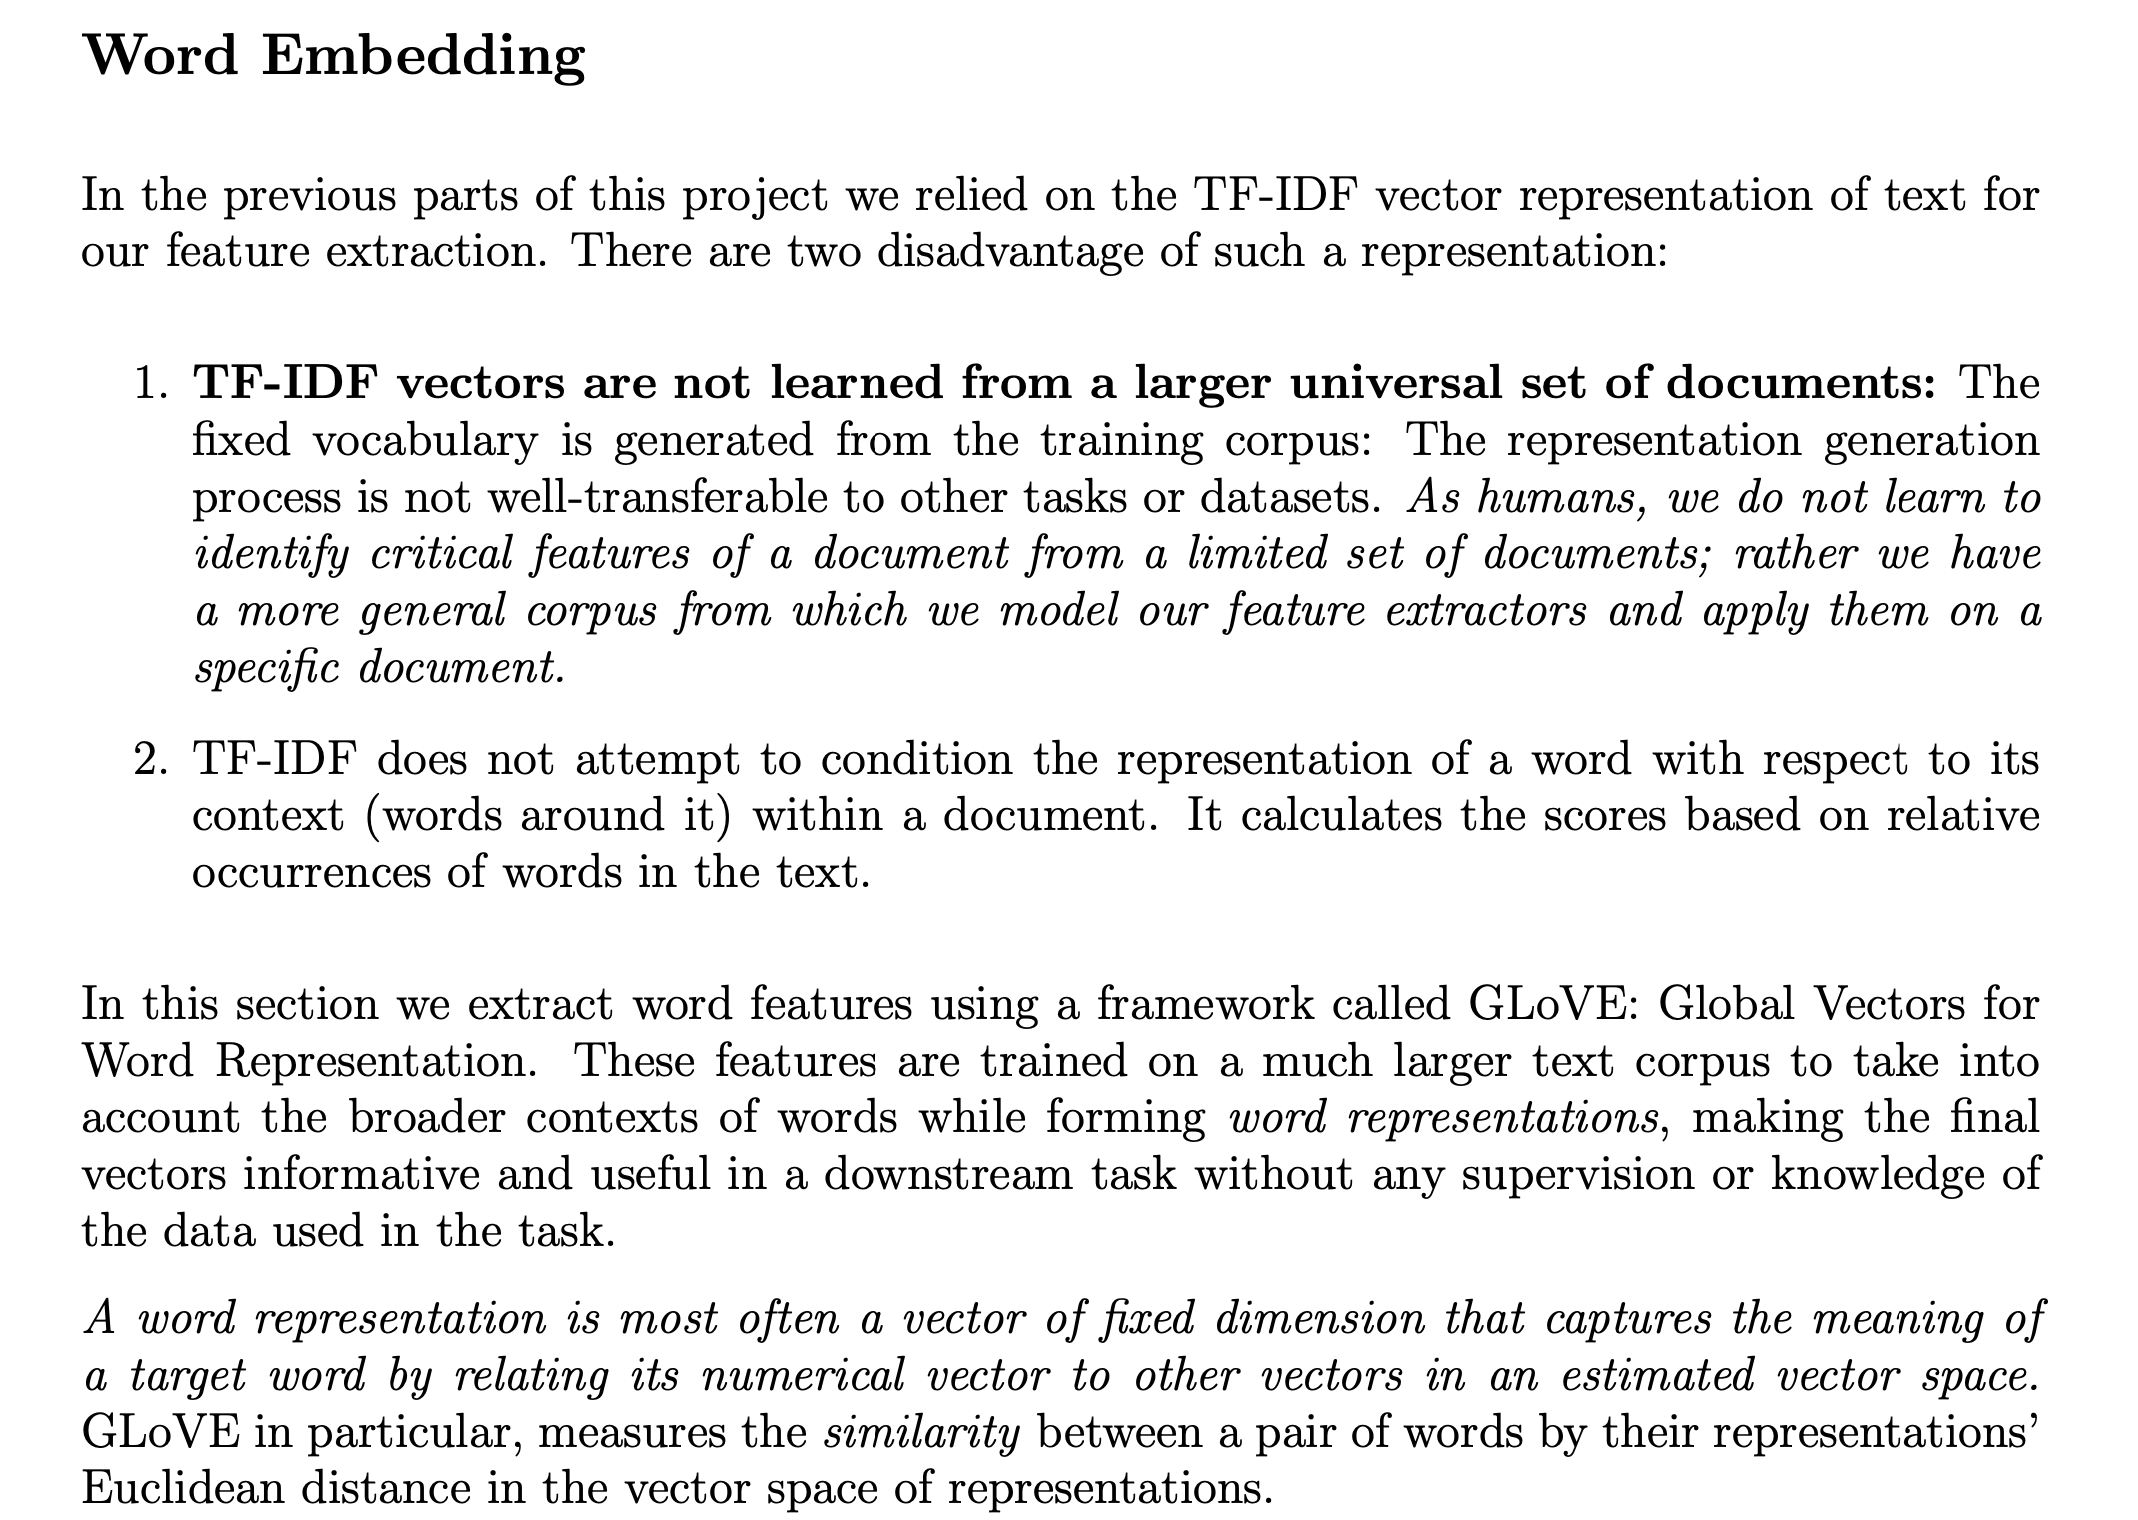

#QUESTION 10: Read the paper about GLoVE embeddings - found here and answer the following subquestions:

  (a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?

  (b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?

  (c) What do you expect for the values of,

      ||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2
      ||GLoVE["queen"] - GLoVE["king"]||2 
      ||GLoVE["wife"] - GLoVE["husband"]||2 ? Compare these values.

  (d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?

# GloVE Embeddings

In [ ]:
dimension_of_glove = 300
embeddings_dict = load_glove_embeddings(300)

In [ ]:
np.linalg.norm(embeddings_dict["queen"] - embeddings_dict["king"] - embeddings_dict["wife"] + embeddings_dict["husband"])

6.1650367

In [ ]:
print(np.linalg.norm(embeddings_dict["queen"] - embeddings_dict["king"]))
print(np.linalg.norm(embeddings_dict["wife"] - embeddings_dict["husband"]))

5.966258
3.1520464



#QUESTION 11: For the binary classification task distinguishing the “sports” class and “climate” class:

  (a) Describe a feature engineering process that uses GLoVE word embeddings to represent each document. You have to abide by the following rules:
  
  • A representation of a text segment needs to have a vector dimension that CANNOT exceed the dimension of the GLoVE embedding used per word of the segment.
  
  • You cannot use TF-IDF scores (or any measure that requires looking at the complete dataset) as a pre-processing routine.
  
  • Important: In this section, feel free to use raw features from any column in the original data file not just full text. The column keywords might be useful.
  
  • To aggregate these words into a single vector consider normalizing the final vectors.
  
  (b) Select a classifier model, train and evaluate it with your GLoVE-based feature.

## Feature Engineering Process with GLoVE
1. Use the 'keywords' column of the dataset and perform lemmatization
2. Extract GLoVE embeddings of size 300 for each word for an example
2. Aggregate the vectors by performing normalization
3. Perform training with LogisticRegression

In [ ]:
from sklearn.model_selection import train_test_split
from ast import literal_eval
nltk.download('words')
wnl = nltk.wordnet.WordNetLemmatizer()
words = set(nltk.corpus.words.words())

train, test = train_test_split(news_articles[["keywords","root_label"]], test_size=0.2)

embedding_number = 300
embeddings_dict = load_glove_embeddings(embedding_number)
glove_feature_data = pd.DataFrame([])
vector_aggregator_train = np.zeros((np.shape(train)[0], embedding_number))
vector_aggregator_test = np.zeros((np.shape(test)[0], embedding_number))
vector_matrix = []

print(np.shape(train))
print(np.shape(test))

target_train = train.root_label.tolist()
target_train = (train.root_label == 'sports')

truth_test_labels = test.root_label.tolist()
target_test = (test.root_label == 'sports')

vector_aggregator_train = glove_feature_processing(train, embedding_number, embeddings_dict)

vector_aggregator_test = glove_feature_processing(test, embedding_number, embeddings_dict)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
(1657, 2)
(415, 2)
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
len(target_train)

1657

## Train Classifier

gamma: auto
Accuracy: 0.9325301204819277
Precision: 0.9495412844036697
Recall: 0.9241071428571429
F-1 Score: 0.9366515837104072


<Figure size 432x288 with 0 Axes>

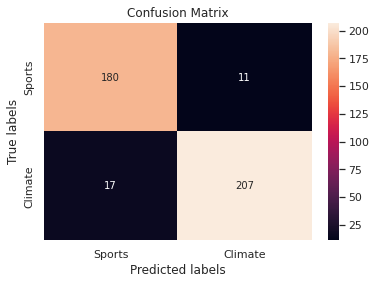

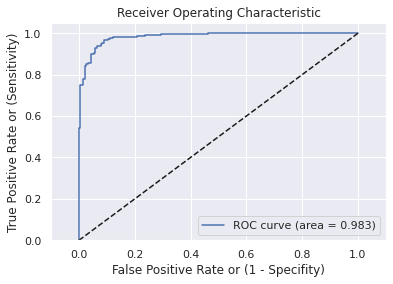

In [ ]:
%matplotlib inline

clf = LogisticRegression(random_state=0, penalty = 'l2', max_iter = 500, C=1000).fit(vector_aggregator_train, target_train)
predicted = clf.predict(vector_aggregator_test)
prob = clf.predict_proba(vector_aggregator_test)
perform_lr_prediction(predicted, prob, vector_aggregator_train, vector_aggregator_test, target_train, target_test, gamma='auto')



#QUESTION 12: 

Plot the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task. Describe the observed trend. Is this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the link.

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


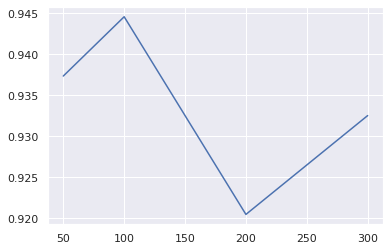

In [ ]:

glove_embedding_nums = [50, 100, 200, 300]
accuracies = []

for num in glove_embedding_nums:
  embeddings_dict = load_glove_embeddings(num)
  vector_aggregator_train = glove_feature_processing(train, num, embeddings_dict)
  vector_aggregator_test = glove_feature_processing(test, num, embeddings_dict)

  clf = LogisticRegression(random_state=0, penalty = 'l2', max_iter = 500, C=1000).fit(vector_aggregator_train, target_train)
  predicted = clf.predict(vector_aggregator_test)
  accuracies.append(metrics.accuracy_score(target_test.ravel(), predicted))
  # prob = clf.predict_proba(vector_aggregator_test)
  # perform_lr_prediction(predicted, prob, vector_aggregator_train, vector_aggregator_test, target_train, target_test, gamma='auto')

plt.plot(glove_embedding_nums, accuracies)


Text(0, 0.5, 'Testing Accuracy')

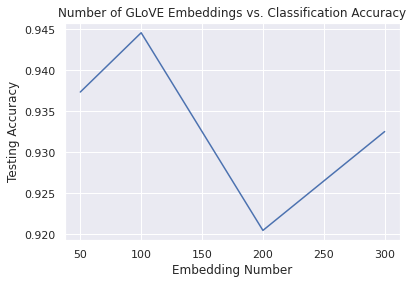

In [ ]:
plt.plot(glove_embedding_nums, accuracies)
plt.title('Number of GLoVE Embeddings vs. Classification Accuracy')
plt.xlabel('Embedding Number')
plt.ylabel('Testing Accuracy')

## UMAP Visualization

In [ ]:
!pip install umap-learn
!pip install umap-learn[plot]

     |████████████████████████████████| 88 kB 7.3 MB/s 
     |████████████████████████████████| 1.1 MB 61.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=573e541ccb4c8214e72f359814768f0b613247c97466a49239127b5fc3d28a62
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=68a571f431d4e67d01794a5b884abfa7dc4ad455df6002082abbbd89a81f5145
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent
     |████████████████████████████████| 15.8 MB 26.7 MB/s 
     |████████████████████████████████| 76 kB 6.5 MB/s 
     |████████████████████████████████| 136 kB 63.6 MB/s 
     |████████████████████████████████| 837 kB 58.7 MB/s 
     |████████████████████████████████| 830 kB 69.4 MB/s 
     |█████████████████

#QUESTION 13:
Compare and contrast the two visualizations. Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project.

In [ ]:
import umap
import umap.plot
import plotly.express as px

target_train = train.root_label.tolist()
target_test = test.root_label.tolist()

target_train_reshaped = np.array(target_train).reshape(-1,1)
target_test_reshaped = np.array(target_test).reshape(-1,1)

all_glove_embeddings = np.vstack([vector_aggregator_train, vector_aggregator_test])
all_labels = np.vstack([target_train_reshaped, target_test_reshaped])
mapper = umap.UMAP(spread=5, min_dist=0.01, a=50, b=.9).fit(all_glove_embeddings)

proj_2d = mapper.transform(all_glove_embeddings)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=np.squeeze(all_labels), labels=['sports', 'climate'],
    title="UMAP Visualization of All GLoVE Embeddings")
fig_2d.show()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
random_vec = np.random.normal(3, 2.5, size=all_glove_embeddings.shape)

proj_2d = mapper.transform(random_vec)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    title="UMAP Visualization of Random Normal Vectors")
fig_2d.show()